In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold, output, info

## directory where results are
CHANSEY_ROOT = "W:"
EXPERIMENT_DIR = f"{CHANSEY_ROOT}/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
RESULTS_DIR = f"{TEAMS_DIR}/fairness-analysis-results"
FIG_DIR = f"{TEAMS_DIR}/figs"
TAB_DIR = f"{TEAMS_DIR}/tables"

In [2]:
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']
TABLE_SCORE_PRECISION = 2
MIN_MAL = 15
TOP_N_CONFOUNDERS = 10

In [3]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB


In [4]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

# Materials

## Demographic characteristics of the NLST validation sets (n=5911 scans, n=1172 scans).

In [5]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [6]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [7]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
    "Partial (malignant)": nlstval_some_mal,
    "Partial (benign)": nlstval_some_ben,
    # "Partial (all)": nlst_1172,
}

In [8]:
cat_df0 = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
cat_df = cat_df0.copy(deep=True)
for s in validation_sets:
    cat_df[f"{s}_info"] = cat_df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_df = cat_df[['category', 'attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))[[f"{s}_info" for s in validation_sets]]

In [9]:

attribute_valid_subgroups_1172 = cat_df0[cat_df0['Partial (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_1172 = list(attribute_valid_subgroups_1172[attribute_valid_subgroups_1172 < 2].index)

attribute_valid_subgroups_5911 = cat_df0[cat_df0['Full (malignant)_freq'] > 15][['attribute', 'value', 'Partial (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_5911 = list(attribute_valid_subgroups_5911[attribute_valid_subgroups_5911 < 2].index)

total_categorical_columns = cat_df0['attribute'].nunique()
print("invalid:", len(invalid_attributes_5911), len(invalid_attributes_1172))
print("valid:", total_categorical_columns - len(invalid_attributes_5911), total_categorical_columns - len(invalid_attributes_1172))

invalid: 36 59
valid: 49 26


In [10]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[(num_df['value'].isin(['Median (IQR)']))][['category', 'attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))[[f"{s}" for s in validation_sets]]

In [11]:
multicol_idx = pd.MultiIndex.from_tuples([
    ('Full Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('Full Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('Full Dataset (n=5911 Scans)', 'Total'),
    ('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)'),
    ('Partial Dataset (n=1172 Scans)', 'Benign (n=1045)'),
    # ('Partial Dataset (n=1172 Scans)', 'Total'),
])

cat_df.columns = multicol_idx
num_df.columns = multicol_idx

In [12]:
df_out = pd.concat([cat_df, num_df], axis=0)
df_out

Full Dataset (n=5911 Scans)  \
                                                                Malignant (n=581)   
category     attribute              value                                           
Demographics BMI                    < 25                               209 (36.0)   
                                    ≥ 25                               372 (64.0)   
             Education Status       8th grade or less                     9 (1.5)   
                                    9th-11th grade                       32 (5.5)   
                                    Associate Degree                   126 (21.7)   
...                                                                           ...   
Smoking      Total Years of Smoking Median (IQR)                          44 (10)   
             Pack-Years             Median (IQR)                          56 (39)   
Other        Nodules Per Scan       Median (IQR)                            2 (2)   
             Diameter (mm)          Median (IQR)                           12 (9)   
             Slices In Scan         Median (IQR)                         162 (40)   

                                                                       \
                                                      Benign (n=5330)   
category     attribute              value                               
Demographics BMI                    < 25                  1690 (31.7)   
                                    ≥ 25                  3640 (68.3)   
             Education Status       8th grade or less       102 (1.9)   
                                    9th-11th grade          258 (4.8)   
                                    Associate Degree      1175 (22.0)   
...                                                               ...   
Smoking      Total Years of Smoking Median (IQR)              41 (10)   
             Pack-Years             Median (IQR)              50 (28)   
Other        Nodules Per Scan       Median (IQR)                1 (1)   
             Diameter (mm)          Median (IQR)                6 (4)   
             Slices In Scan         Median (IQR)             160 (38)   

                                                      Partial Dataset (n=1172 Scans)  \
                                                                   Malignant (n=127)   
category     attribute              value                                              
Demographics BMI                    < 25                                   45 (35.4)   
                                    ≥ 25                                   82 (64.6)   
             Education Status       8th grade or less                        4 (3.1)   
                                    9th-11th grade                           2 (1.6)   
                                    Associate Degree                       31 (24.4)   
...                                                                              ...   
Smoking      Total Years of Smoking Median (IQR)                             44 (10)   
             Pack-Years             Median (IQR)                             64 (35)   
Other        Nodules Per Scan       Median (IQR)                               2 (1)   
             Diameter (mm)          Median (IQR)                              11 (9)   
             Slices In Scan         Median (IQR)                            162 (43)   

                                                                       
                                                      Benign (n=1045)  
category     attribute              value                              
Demographics BMI                    < 25                   326 (31.2)  
                                    ≥ 25                   719 (68.8)  
             Education Status       8th grade or less        23 (2.2)  
                                    9th-11th grade           65 (6.2)  
                                    Associate Degree       213 (20.4)  
...                            

In [13]:
df_out2 = df_out.xs('Demographics', level='category')
df_out2

Full Dataset (n=5911 Scans)  \
                                                         Malignant (n=581)   
attribute                  value                                             
BMI                        < 25                                 209 (36.0)   
                           ≥ 25                                 372 (64.0)   
Education Status           8th grade or less                       9 (1.5)   
                           9th-11th grade                         32 (5.5)   
                           Associate Degree                     126 (21.7)   
                           Bachelors Degree                      96 (16.5)   
                           Graduate School                       76 (13.1)   
                           HS Graduate / GED                    141 (24.3)   
                           Post-HS training                      87 (15.0)   
Gender                     Female                               244 (42.0)   
                           Male                                 337 (58.0)   
Married                    False                                197 (33.9)   
                           True                                 384 (66.1)   
HS Education               False                                   9 (1.5)   
                           True                                 572 (98.5)   
Non-Hispanic White         False                                  55 (9.5)   
                           True                                 526 (90.5)   
Unfinished Education Level False                                423 (72.8)   
                           True                                 158 (27.2)   
White or Black             Black                                  28 (4.8)   
                           White                                530 (91.2)   
Marital Status             Divorced                             125 (21.5)   
                           Married                              384 (66.1)   
                           Never Married                          16 (2.8)   
                           Separated                               5 (0.9)   
                           Widowed                                49 (8.4)   
Ethnicity                  Hispanic/Latino                         4 (0.7)   
                           Not Hispanic/Latino                  574 (98.8)   
Race                       Asian                                   6 (1.0)   
                           Black                                  28 (4.8)   
                           More than one race                      6 (1.0)   
                           Native American                         8 (1.4)   
                           Native Hawaiian                         1 (0.2)   
                           White                                530 (91.2)   
Body Mass Index            Median (IQR)                             26 (4)   
Age                        Median (IQR)                             64 (8)   
Height                     Median (IQR)                             68 (6)   
Weight                     Median (IQR)                           175 (50)   

                                                                \
                                               Benign (n=5330)   
attribute                  value                                 
BMI                        < 25                    1690 (31.7)   
                           ≥ 25                    3640 (68.3)   
Education Status           8th grade or less         102 (1.9)   
                           9th-11th grade            258 (4.8)   
                           Associate Degree        1175 (22.0)   
                           Bachelors Degree         817 (15.3)   
                           Graduate School          778 (14.6)   
                           HS Graduate / GED       1338 (25.1)   
                           Post-HS training         765 (14.4)   
Gender                     Female                  2226 

In [14]:
print(df_out2.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). HS = High School.'))

None


## DLCST vs. NLST

In [15]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, info.DLCST_DEMOCOLS)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [16]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [17]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [18]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Gender               Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Gender               Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Gender               Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Gender               Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)

In [19]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [20]:
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=output.DLCST_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

In [21]:
nlst_1172, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
nlst_1172_policies, _ = threshold.get_threshold_policies(nlst_1172, models=output.NLST_1172_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [22]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=output.NLST_5911_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:474: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [23]:
policy_dfs = {
    "DLCST (n=599)": dlcst_policies.copy(deep=True), 
    "NLST Partial (n=1172)": nlst_1172_policies.copy(deep=True), 
    "NLST Full (n=5911)": nlst_5911_policies.copy(deep=True)
}

for val in policy_dfs:
    if 'Brock' in policy_dfs[val].columns:
        policy_dfs[val].drop(columns='Brock', inplace=True)
    policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
combined_policies = combined_policies[combined_policies.index != 'De Haas Global (Shown Nodule)']
combined_policies

DLCST (n=599)                  NLST Partial (n=1172)  \
                 90\% Sensitivity 90\% Specificity      90\% Sensitivity   
Venkadesh                   0.134            0.204                   NaN   
Sybil (Year 1)              0.001            0.018                   NaN   
PanCan2b                    0.020            0.093                   NaN   
De Haas Local                 NaN              NaN                 0.049   
De Haas Global                NaN              NaN                 0.060   
De Haas Combined            0.099            0.193                 0.069   

                                  NLST Full (n=5911)                   
                 90\% Specificity   90\% Sensitivity 90\% Specificity  
Venkadesh                     NaN              0.048            0.220  
Sybil (Year 1)                NaN              0.003            0.058  
PanCan2b                      NaN              0.015            0.165  
De Haas Local               0.214              0.044            0.212  
De Haas Global              0.235              0.066            0.241  
De Haas Combined            0.261                NaN              NaN

In [24]:
print(combined_policies.style.format(precision=3, na_rep='\\verb|-|').to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on DLCST and both NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \cite{Lim2020-ilst}.'))

None


# Results

## ROC Tables

### DLCST

In [25]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'de Haas', 'Sybil year 1', 'PanCan2b']
dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_22592\2578401092.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh         De Haas Combined        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age       > 61    0.92 (0.87, 0.97)  None  0.91 (0.85, 0.96)  None   
          ≤ 61    0.92 (0.85, 0.97)   .99  0.92 (0.86, 0.97)   .78   
Gender    Male    0.91 (0.84, 0.96)  None  0.90 (0.84, 0.96)  None   
          Female  0.94 (0.91, 0.97)   .44  0.95 (0.91, 0.98)   .37   

                     Sybil (Year 1)                 PanCan2b        
                            ROC AUC     p            ROC AUC     p  
Attribute Group                                                     
Age       > 61    0.86 (0.78, 0.94)  None  0.85 (0.79, 0.91)  None  
          ≤ 61    0.86 (0.78, 0.93)   .98  0.90 (0.84, 0.95)   .46  
Gender    Male    0.87 (0.78, 0.94)  None  0.91 (0.86, 0.95)  None  
          Female  0.86 (0.78, 0.93)   .88  0.86 (0.79, 0.92)   .35

In [26]:
print(dlcst_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values. No significant demographic biases were found from any of our models on the DLCST cohort.'))

None


### NLST (for Tijmen's combined model only.)

In [27]:
nlst_demos_to_include = ['Age', 'Gender', 'Race', 'HS Education', 'Height', 'Weight', 'BMI']
nlst_tijmen_model_order = ['de Haas Combined', 'de Haas Local', 'de Haas Global (hidden nodule)']

In [28]:
nlst_tijmen_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)

nlst_tijmen_scan_out = output.roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_tijmen_scan_out_demos = nlst_tijmen_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_1172')
nlst_tijmen_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_22592\104166115.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_tijmen_scan_out = output.roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


De Haas Combined            De Haas Local        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age       > 61    0.86 (0.82, 0.90)  None  0.85 (0.81, 0.90)  None   
          ≤ 61    0.88 (0.82, 0.92)   .73  0.88 (0.83, 0.93)   .45   
BMI       ≥ 25    0.87 (0.83, 0.90)  None  0.87 (0.83, 0.91)  None   
          < 25    0.87 (0.82, 0.92)   .91  0.85 (0.79, 0.90)   .57   
Gender    Male    0.87 (0.84, 0.91)  None  0.87 (0.82, 0.91)  None   
          Female  0.86 (0.80, 0.91)   .69  0.87 (0.81, 0.91)   .98   
Height    > 68    0.87 (0.83, 0.91)  None  0.86 (0.82, 0.91)  None   
          ≤ 68    0.87 (0.82, 0.92)   .91  0.87 (0.83, 0.92)   .83   
Weight    ≤ 180   0.86 (0.82, 0.90)  None  0.86 (0.82, 0.90)  None   
          > 180   0.87 (0.83, 0.91)   .83  0.87 (0.82, 0.92)   .71   

                     De Haas Global        
                            ROC AUC     p  
Attribute Group                            
Age       > 61    0.77 (0.73, 0.82)  None  
          ≤ 61    0.77 (0.71, 0.82)   .91  
BMI       ≥ 25    0.78 (0.74, 0.82)  None  
          < 25    0.75 (0.68, 0.81)   .49  
Gender    Male    0.80 (0.75, 0.84)  None  
          Female  0.72 (0.66, 0.78)   .13  
Height    > 68    0.79 (0.74, 0.84)  None  
          ≤ 68    0.75 (0.69, 0.81)   .39  
Weight    ≤ 180   0.74 (0.69, 0.79)  None  
          > 180   0.80 (0.75, 0.85)   .17

In [29]:
print(nlst_tijmen_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenROC.tex",
    hrules=True, label='tab:resNLSTtijmenROC', environment='table*', column_format=f'll{"|ll"*len(nlst_tijmen_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for the De Haas model and its constituent submodels on demographic characteristics when evaluated on the smaller NLST validation set (1172 scans), including p values. Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. No significant demographic biases were found from the De Haas Combined model on this limited set of scans.'))

None


### NLST for all other models

In [30]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = ['Venkadesh',    'de Haas Local', 'de Haas Global (hidden nodule)', 'Sybil year 1', 'PanCan2b']
nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_22592\1823227323.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh            De Haas Local        \
                            ROC AUC     p            ROC AUC     p   
Attribute Group                                                      
Age       > 61    0.88 (0.86, 0.90)  None  0.86 (0.85, 0.88)  None   
          ≤ 61    0.90 (0.88, 0.92)   .14  0.88 (0.86, 0.91)   .33   
BMI       ≥ 25    0.90 (0.88, 0.91)  None  0.87 (0.85, 0.89)  None   
          < 25    0.88 (0.85, 0.90)   .32  0.87 (0.85, 0.90)   .91   
Gender    Male    0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)  None   
          Female  0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)   .40   
Height    ≤ 68    0.89 (0.87, 0.91)  None  0.88 (0.86, 0.90)  None   
          > 68    0.88 (0.86, 0.91)   .67  0.86 (0.84, 0.89)   .35   
Race      White   0.89 (0.88, 0.91)  None  0.87 (0.86, 0.89)  None   
          Black   0.82 (0.74, 0.89)   .14  0.81 (0.72, 0.89)   .21   
Weight    ≤ 180   0.88 (0.87, 0.90)  None  0.87 (0.85, 0.89)  None   
          > 180   0.89 (0.87, 0.91)   .65  0.87 (0.85, 0.89)   .95   

                     De Haas Global           Sybil (Year 1)          \
                            ROC AUC     p            ROC AUC       p   
Attribute Group                                                        
Age       > 61    0.79 (0.77, 0.81)  None  0.84 (0.82, 0.86)    None   
          ≤ 61    0.81 (0.79, 0.83)   .30  0.85 (0.82, 0.88)     .67   
BMI       ≥ 25    0.80 (0.78, 0.82)  None  0.86 (0.84, 0.88)    None   
          < 25    0.79 (0.76, 0.82)   .63  0.81 (0.78, 0.85)     .05   
Gender    Male    0.81 (0.80, 0.83)  None  0.81 (0.78, 0.84)    None   
          Female  0.77 (0.74, 0.80)   .05  0.88 (0.86, 0.90)  < .001   
Height    ≤ 68    0.79 (0.76, 0.81)  None  0.87 (0.85, 0.89)    None   
          > 68    0.80 (0.78, 0.83)   .48  0.80 (0.77, 0.83)  < .001   
Race      White   0.80 (0.78, 0.81)  None  0.84 (0.83, 0.86)    None   
          Black   0.83 (0.76, 0.90)   .45  0.83 (0.74, 0.90)     .77   
Weight    ≤ 180   0.78 (0.75, 0.80)  None  0.84 (0.82, 0.87)    None   
          > 180   0.82 (0.79, 0.84)   .05  0.84 (0.81, 0.87)     .82   

                           PanCan2b        
                            ROC AUC     p  
Attribute Group                            
Age       > 61    0.76 (0.74, 0.79)  None  
          ≤ 61    0.81 (0.78, 0.83)   .05  
BMI       ≥ 25    0.81 (0.79, 0.83)  None  
          < 25    0.73 (0.70, 0.77)  .001  
Gender    Male    0.79 (0.76, 0.81)  None  
          Female  0.78 (0.75, 0.81)   .66  
Height    ≤ 68    0.79 (0.76, 0.81)  None  
          > 68    0.78 (0.75, 0.80)   .71  
Race      White   0.78 (0.76, 0.80)  None  
          Black   0.75 (0.65, 0.83)   .54  
Weight    ≤ 180   0.77 (0.74, 0.79)  None  
          > 180   0.80 (0.77, 0.82)   .13

In [31]:
print(nlst_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the larger NLST validation set (5911 scans), including p values. Sybil has significant demographic biases against men, people above 68 inches tall, and married indivivduals.'))

None


## Threshold Utilities

In [32]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, info.DLCST_DEMOCOLS)
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = output.threshold_stats_pretty(threshold_dlcst, dlcst_policies)

In [33]:
threshold_nlst_1172 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-1172.csv', index_col=0)
threshold_nlst_1172, nlst_1172_policies = output.threshold_stats_pretty(threshold_nlst_1172, nlst_1172_policies)

In [34]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = output.threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

## Threshold Plots

### DLCST

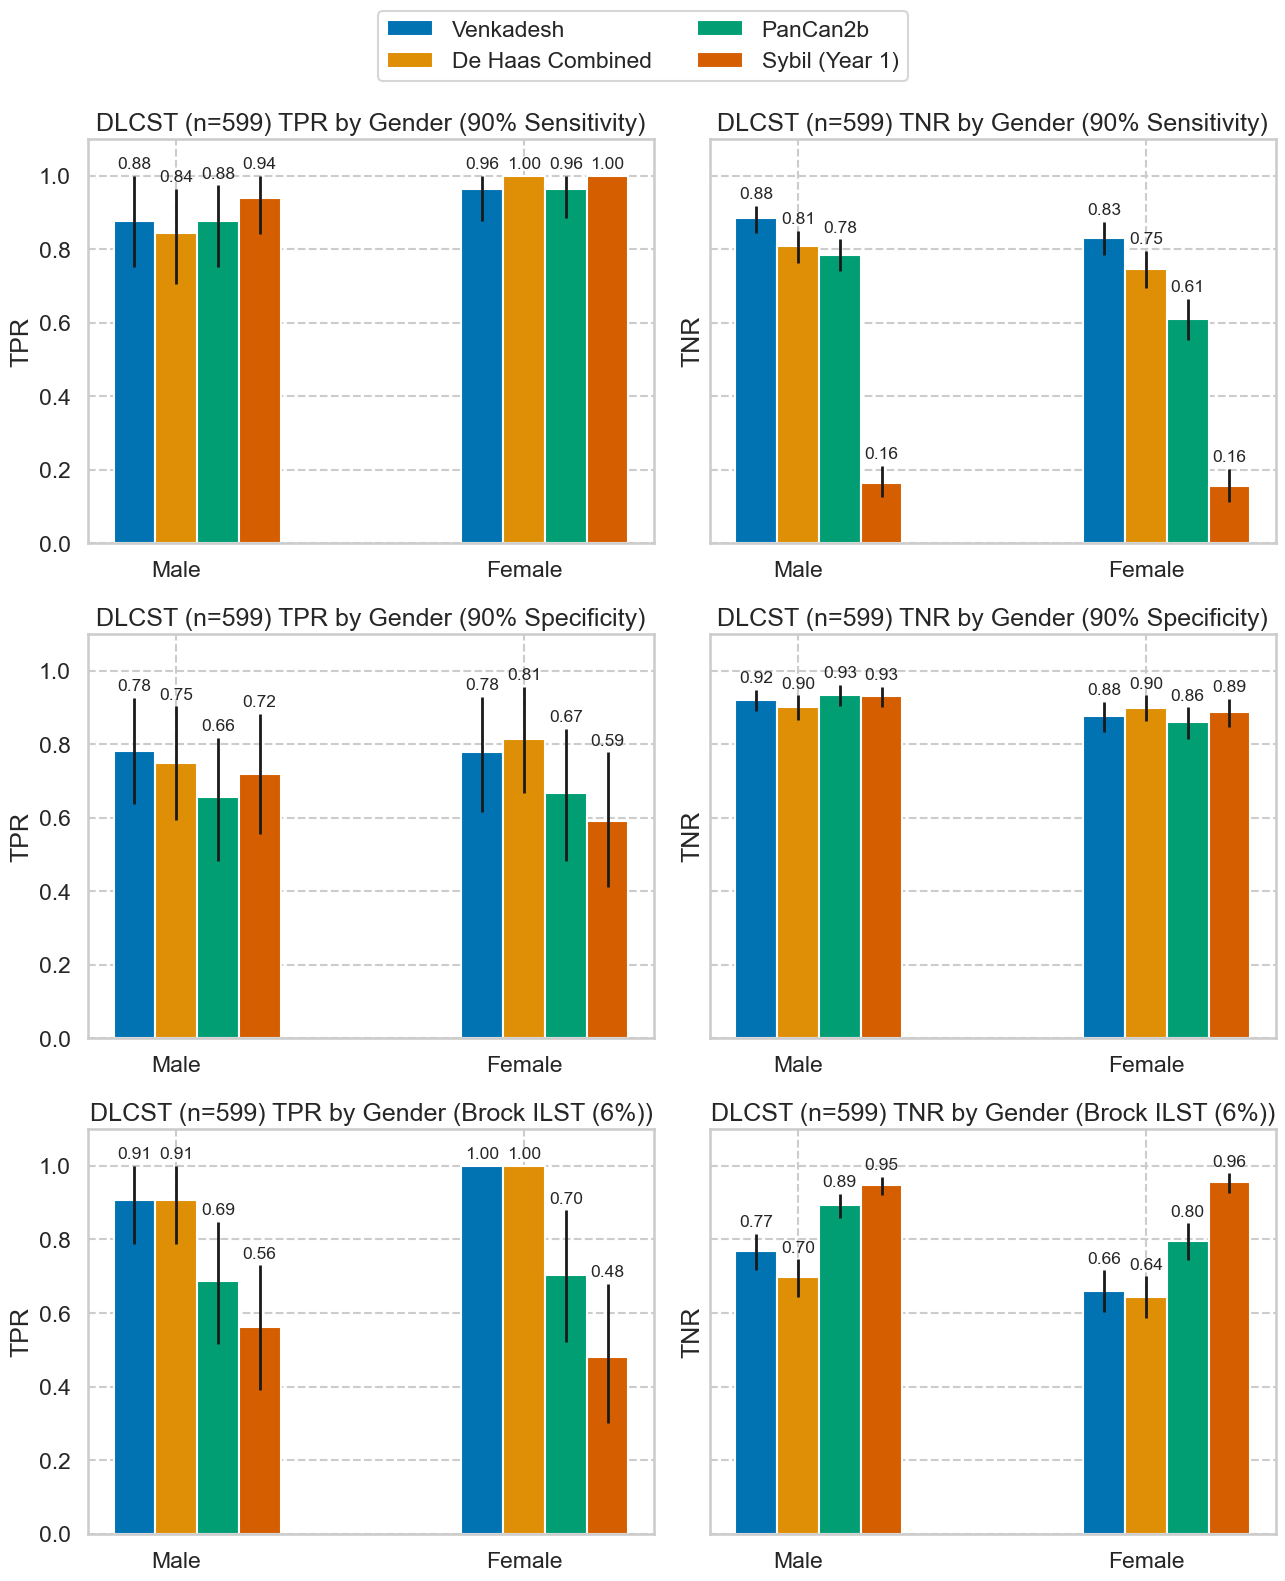

In [35]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Gender', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Gender"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

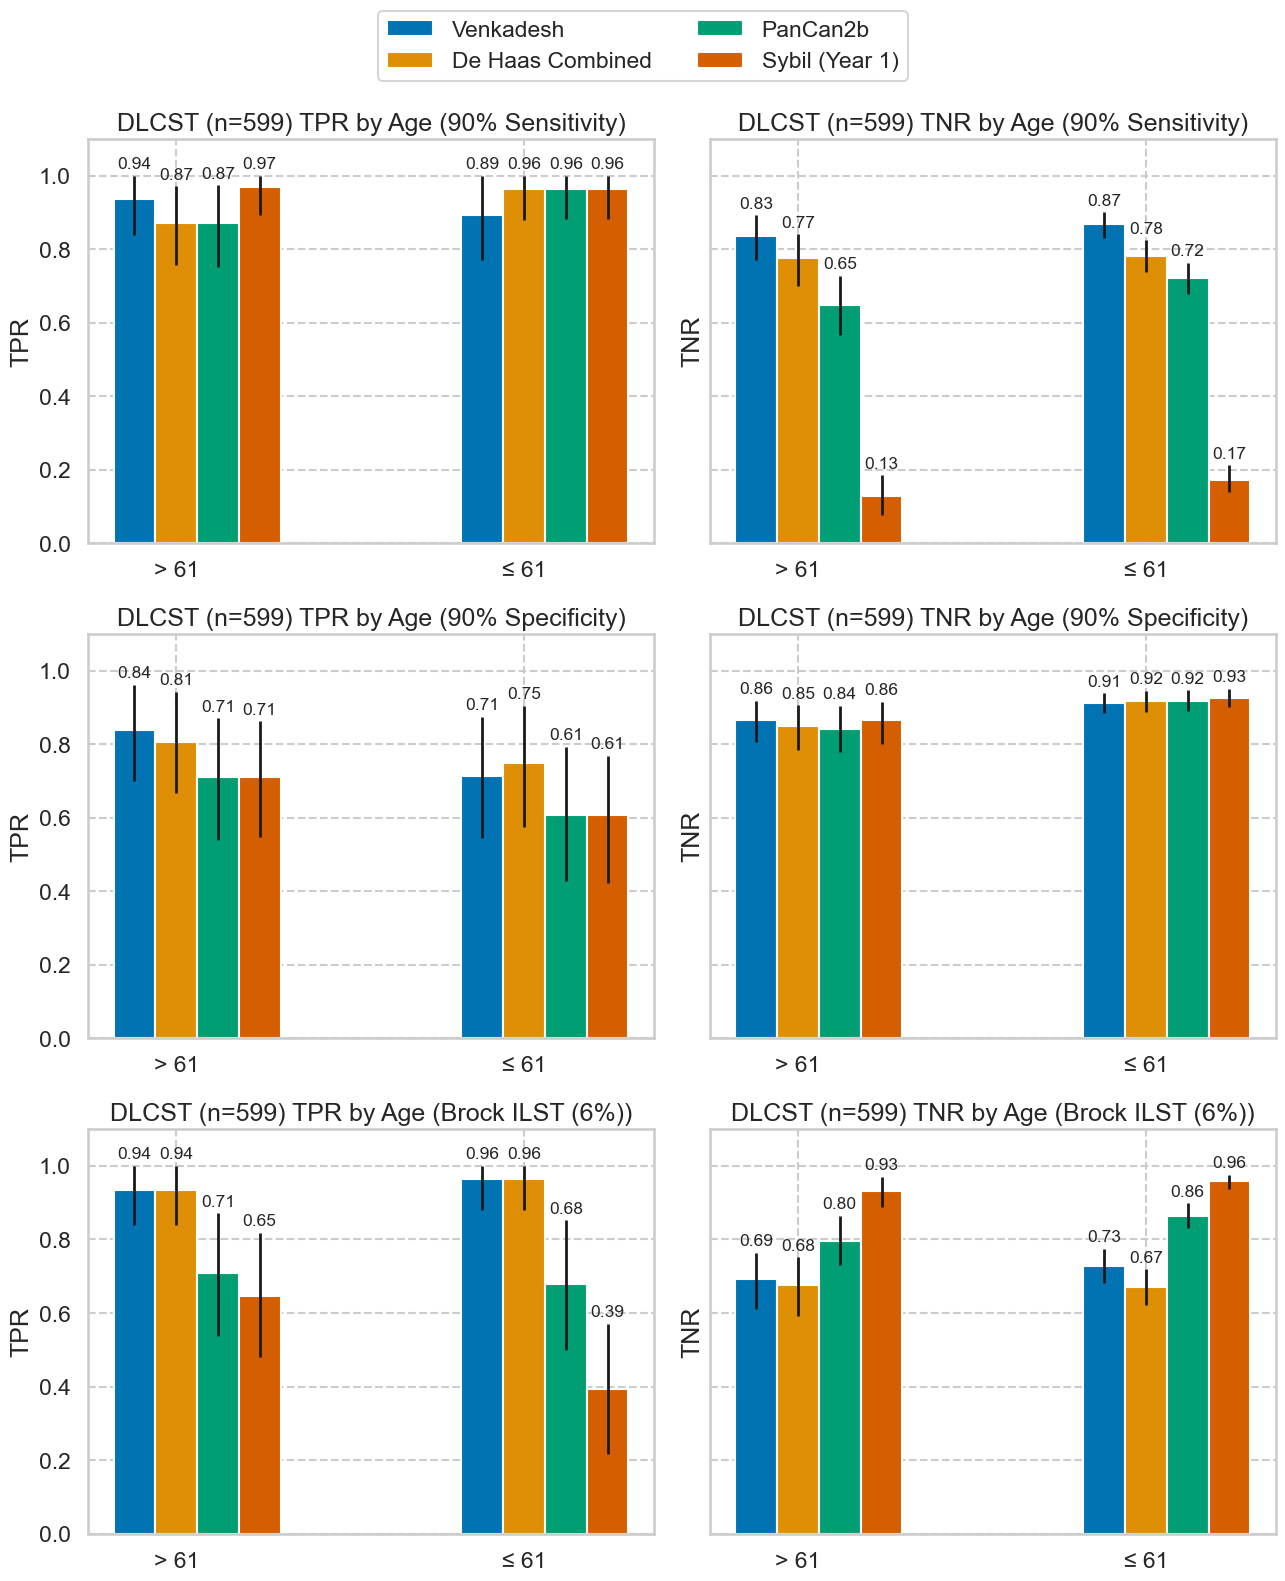

In [36]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST (1172)

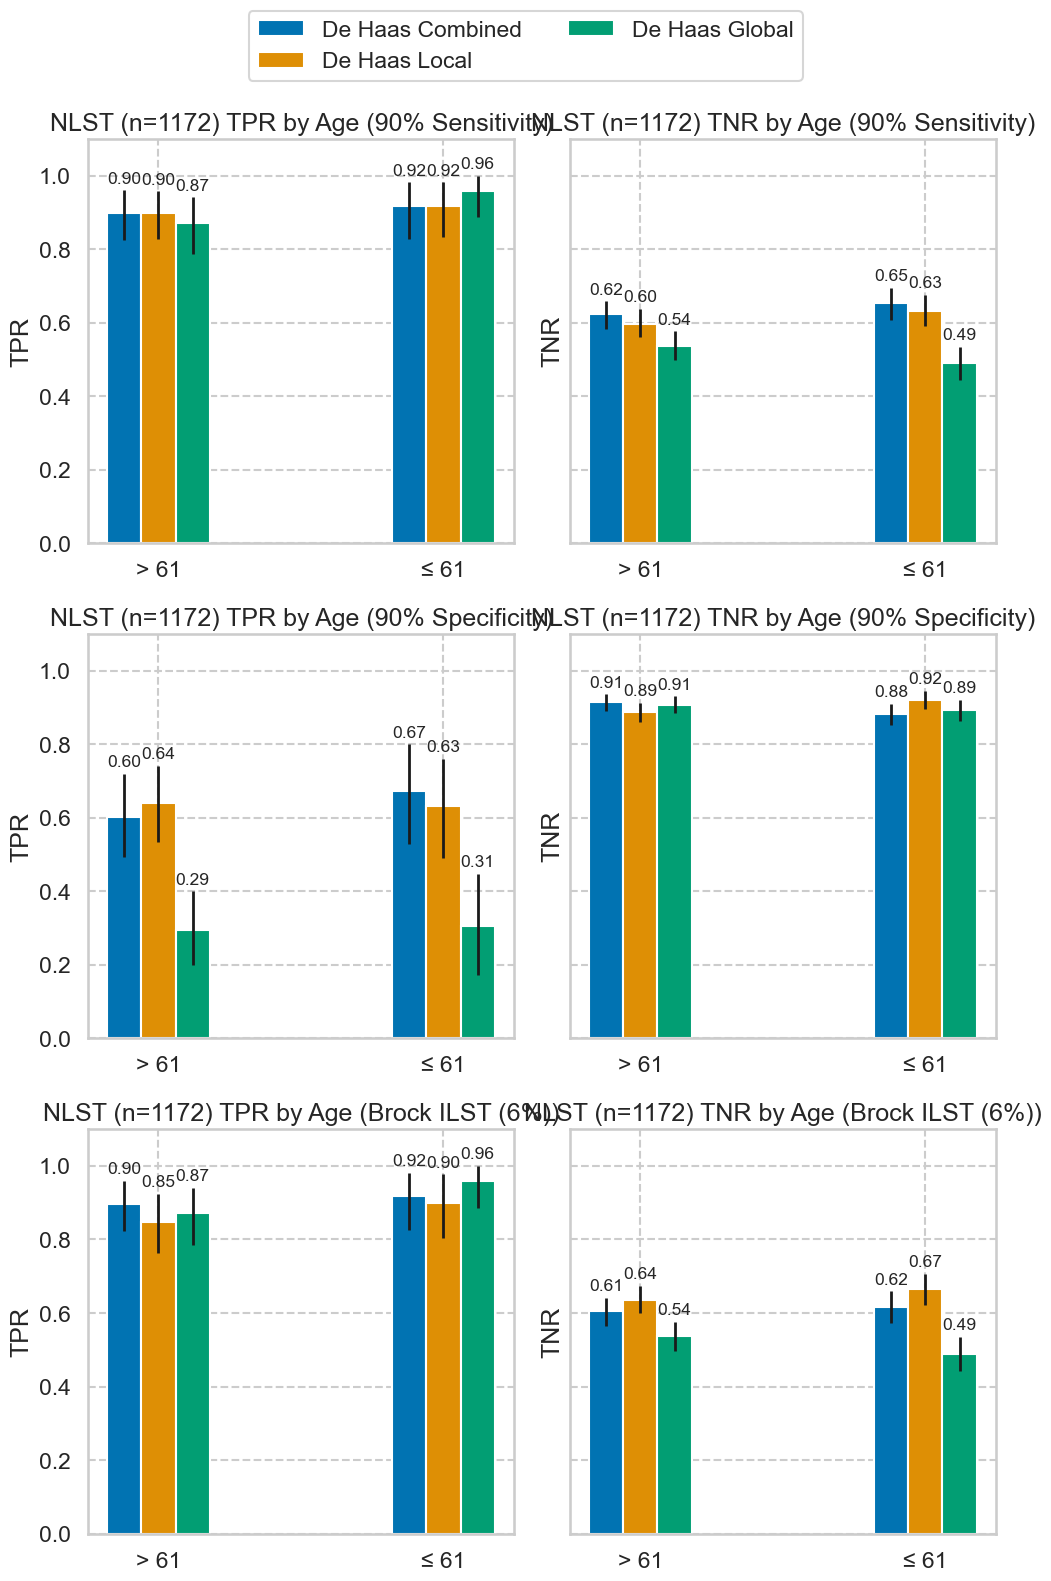

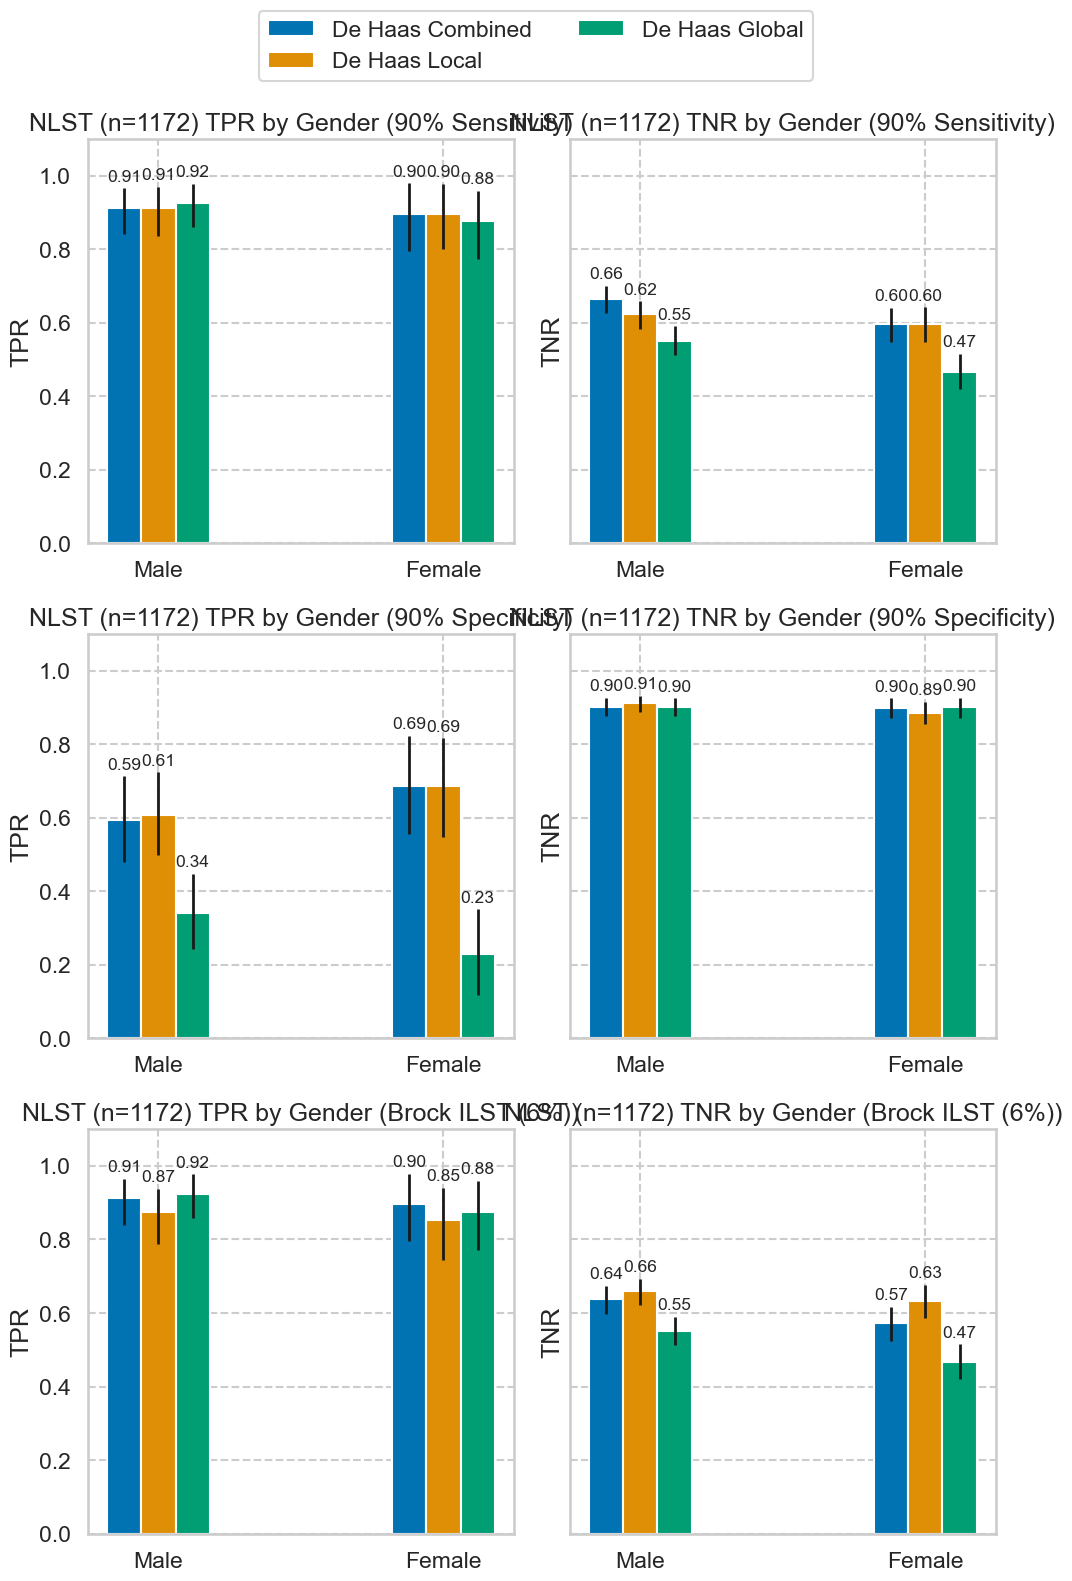

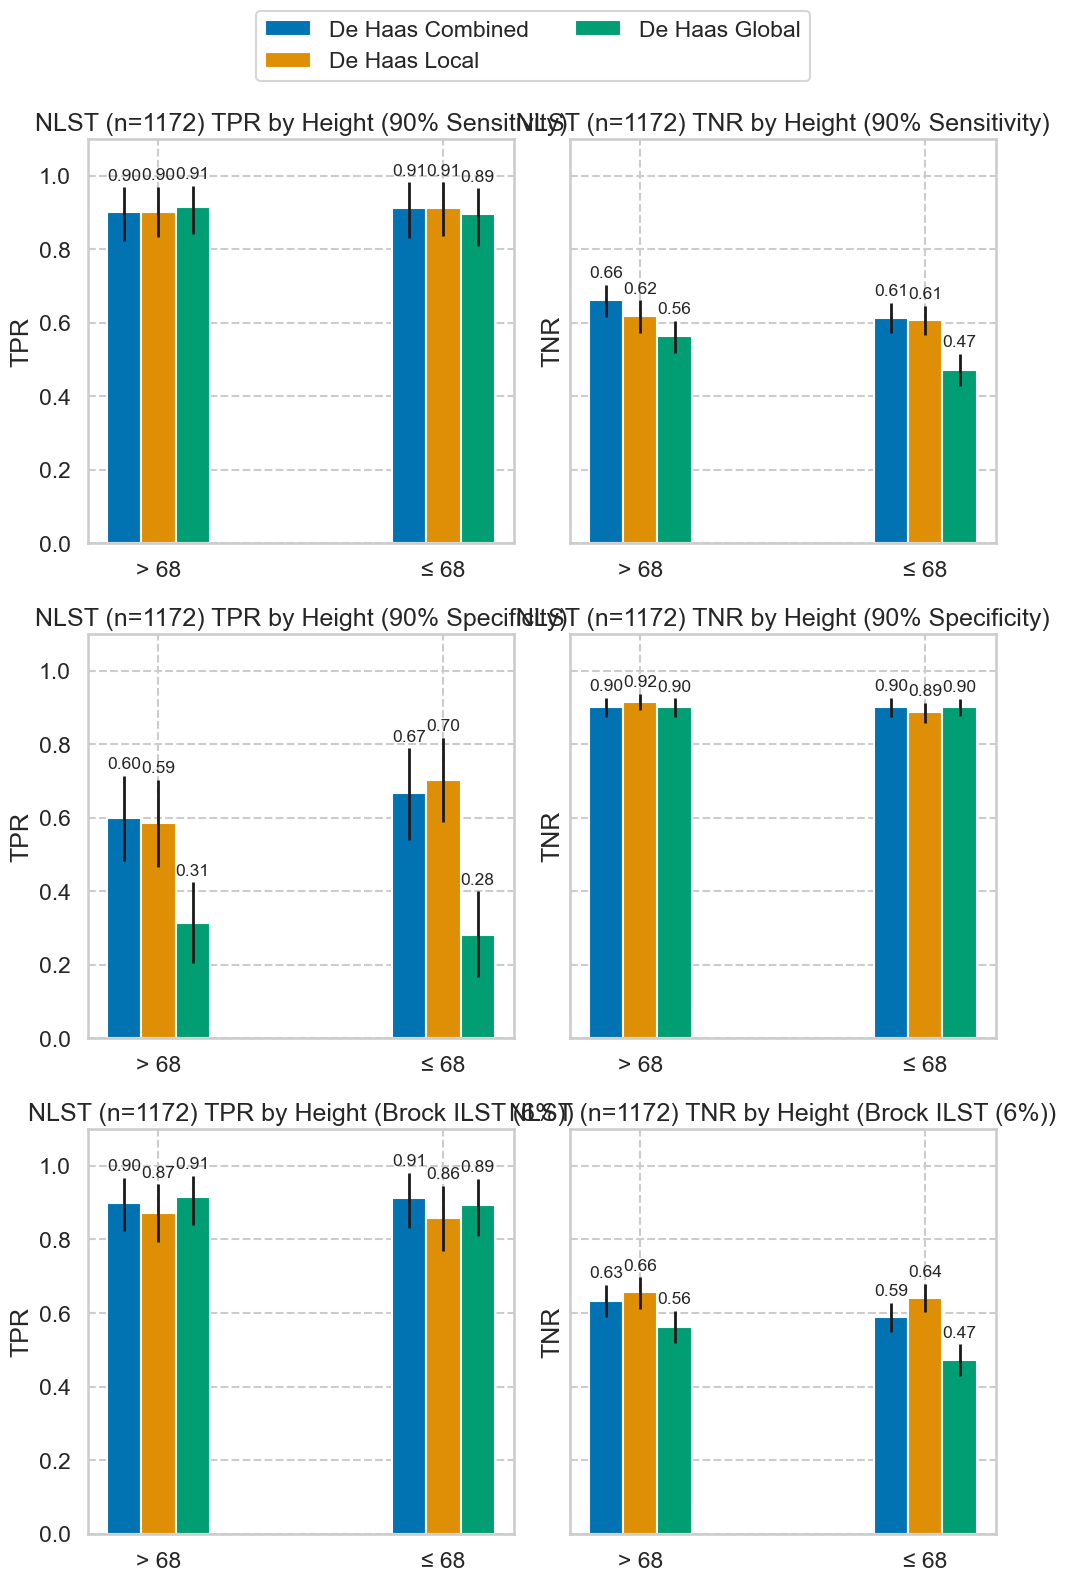

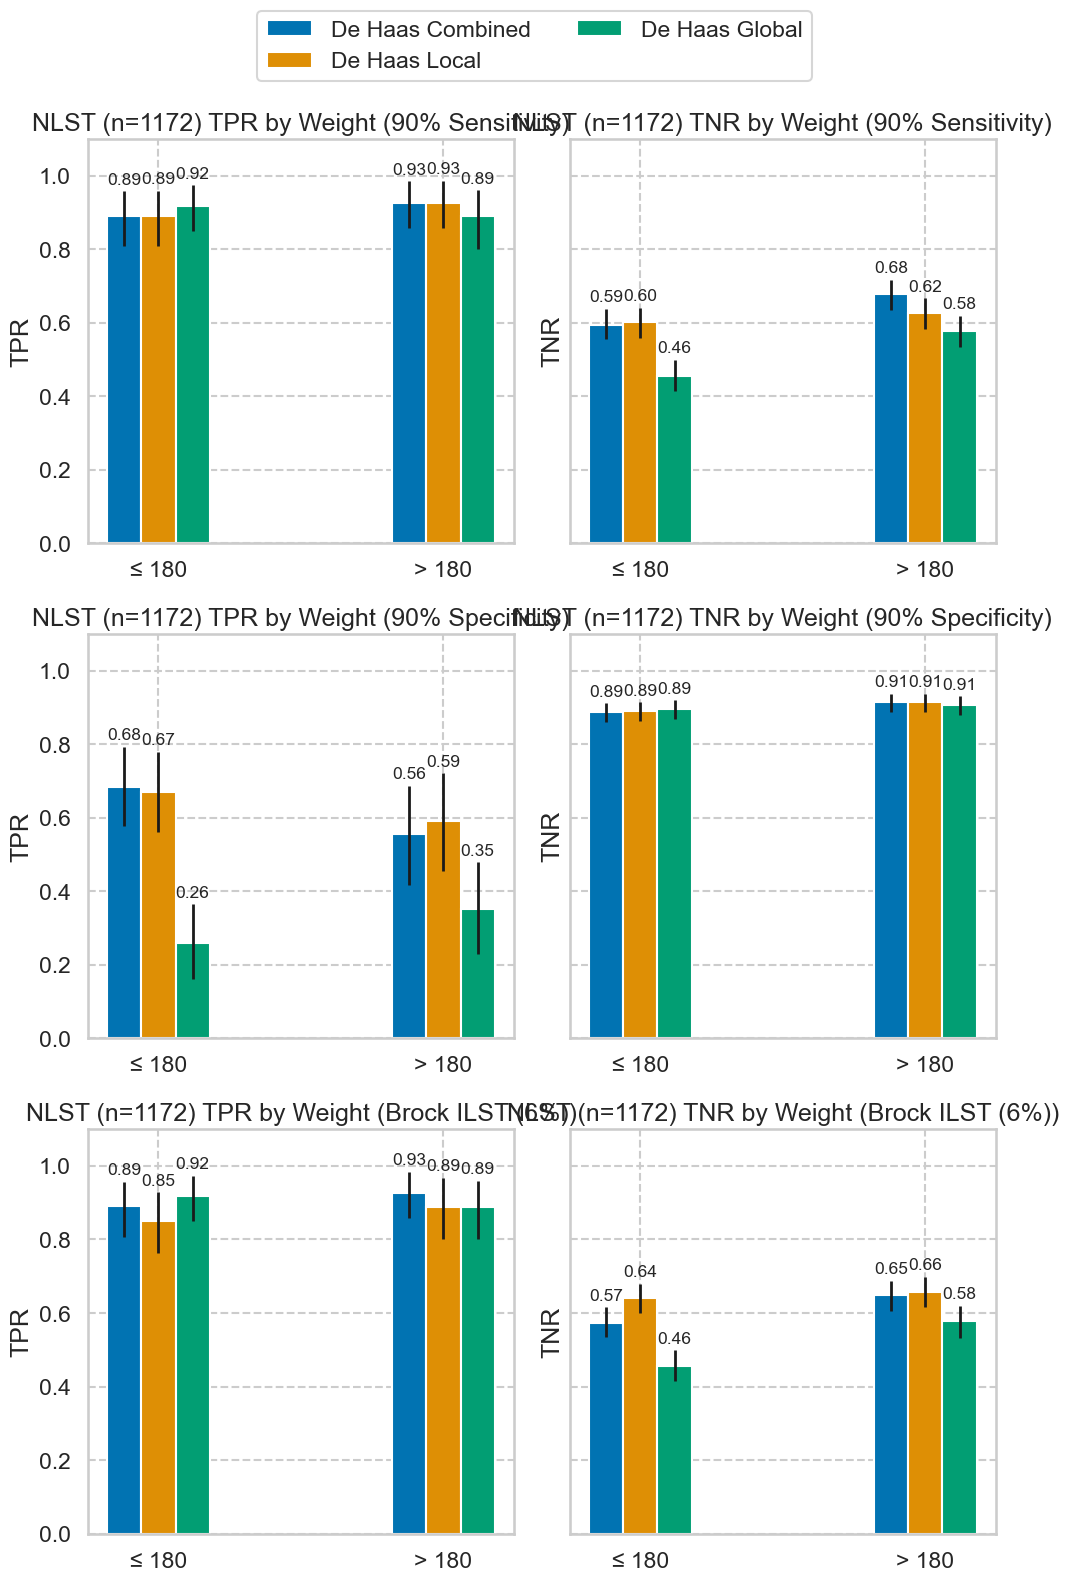

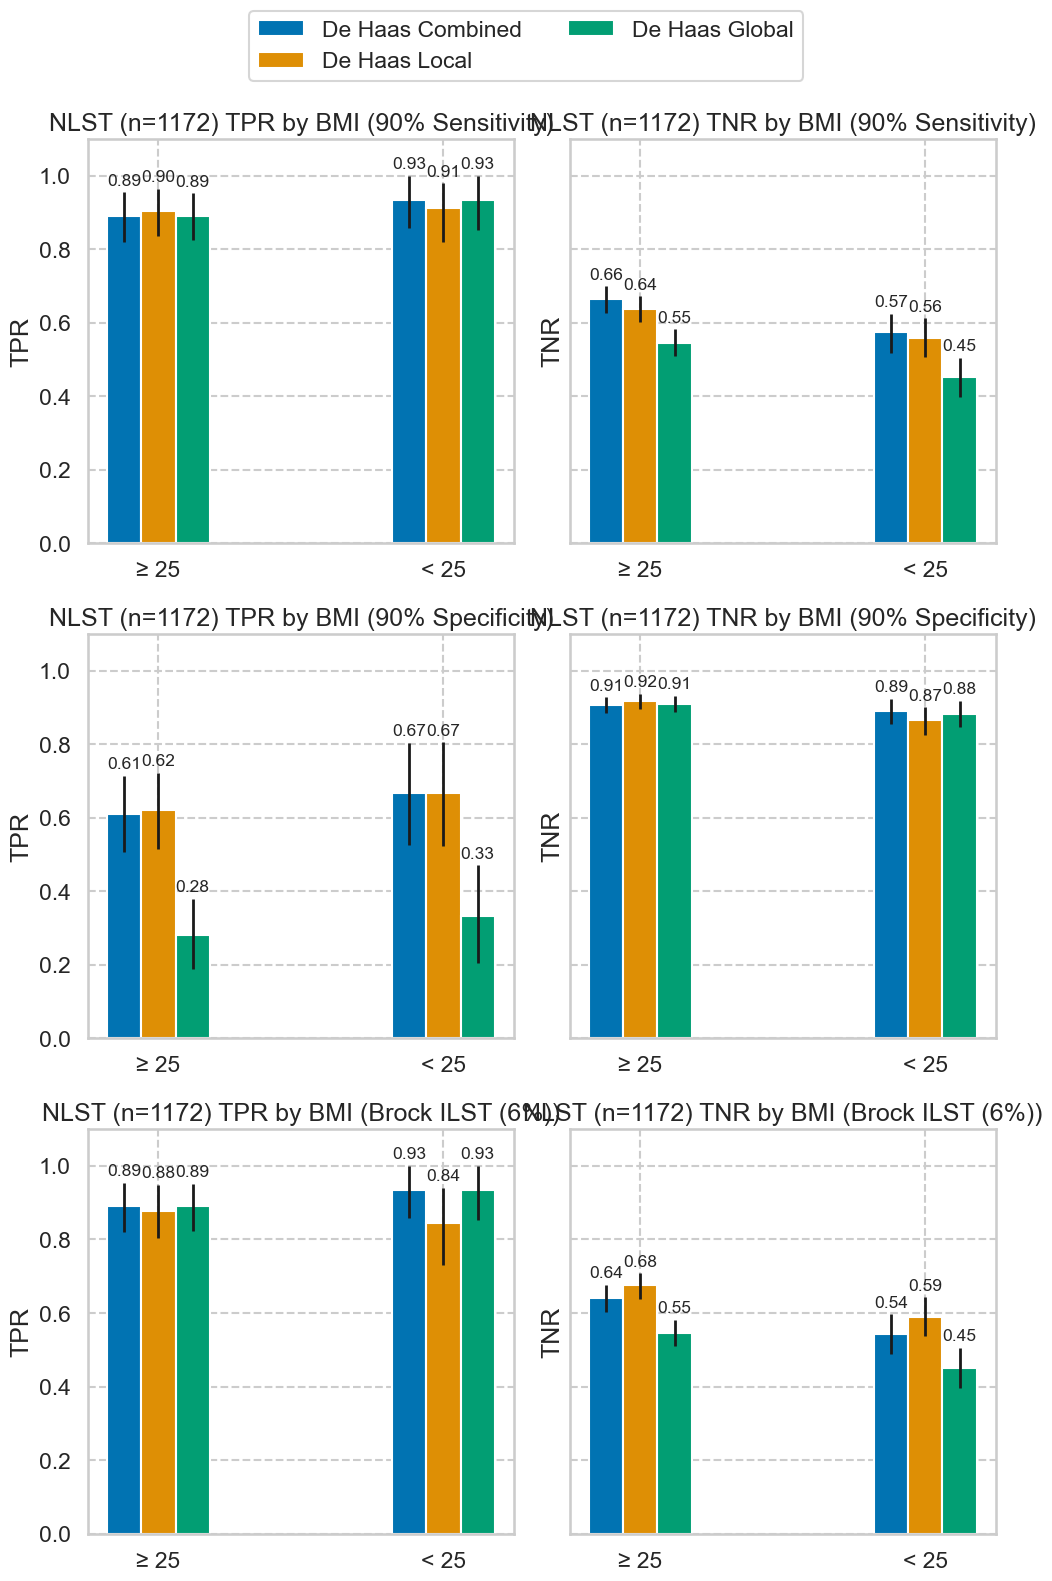

In [37]:
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_1172, col, dataset_name='NLST',
                                                policies=nlst_1172_policies, models=output.NLST_1172_MODELCOLS, 
                                                stats=threshold_nlst_1172.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-1172/{col}.png"
                                                )  

### NLST 5911


['Age', 'Gender', 'Race', 'HS Education', 'Height', 'Weight', 'BMI']


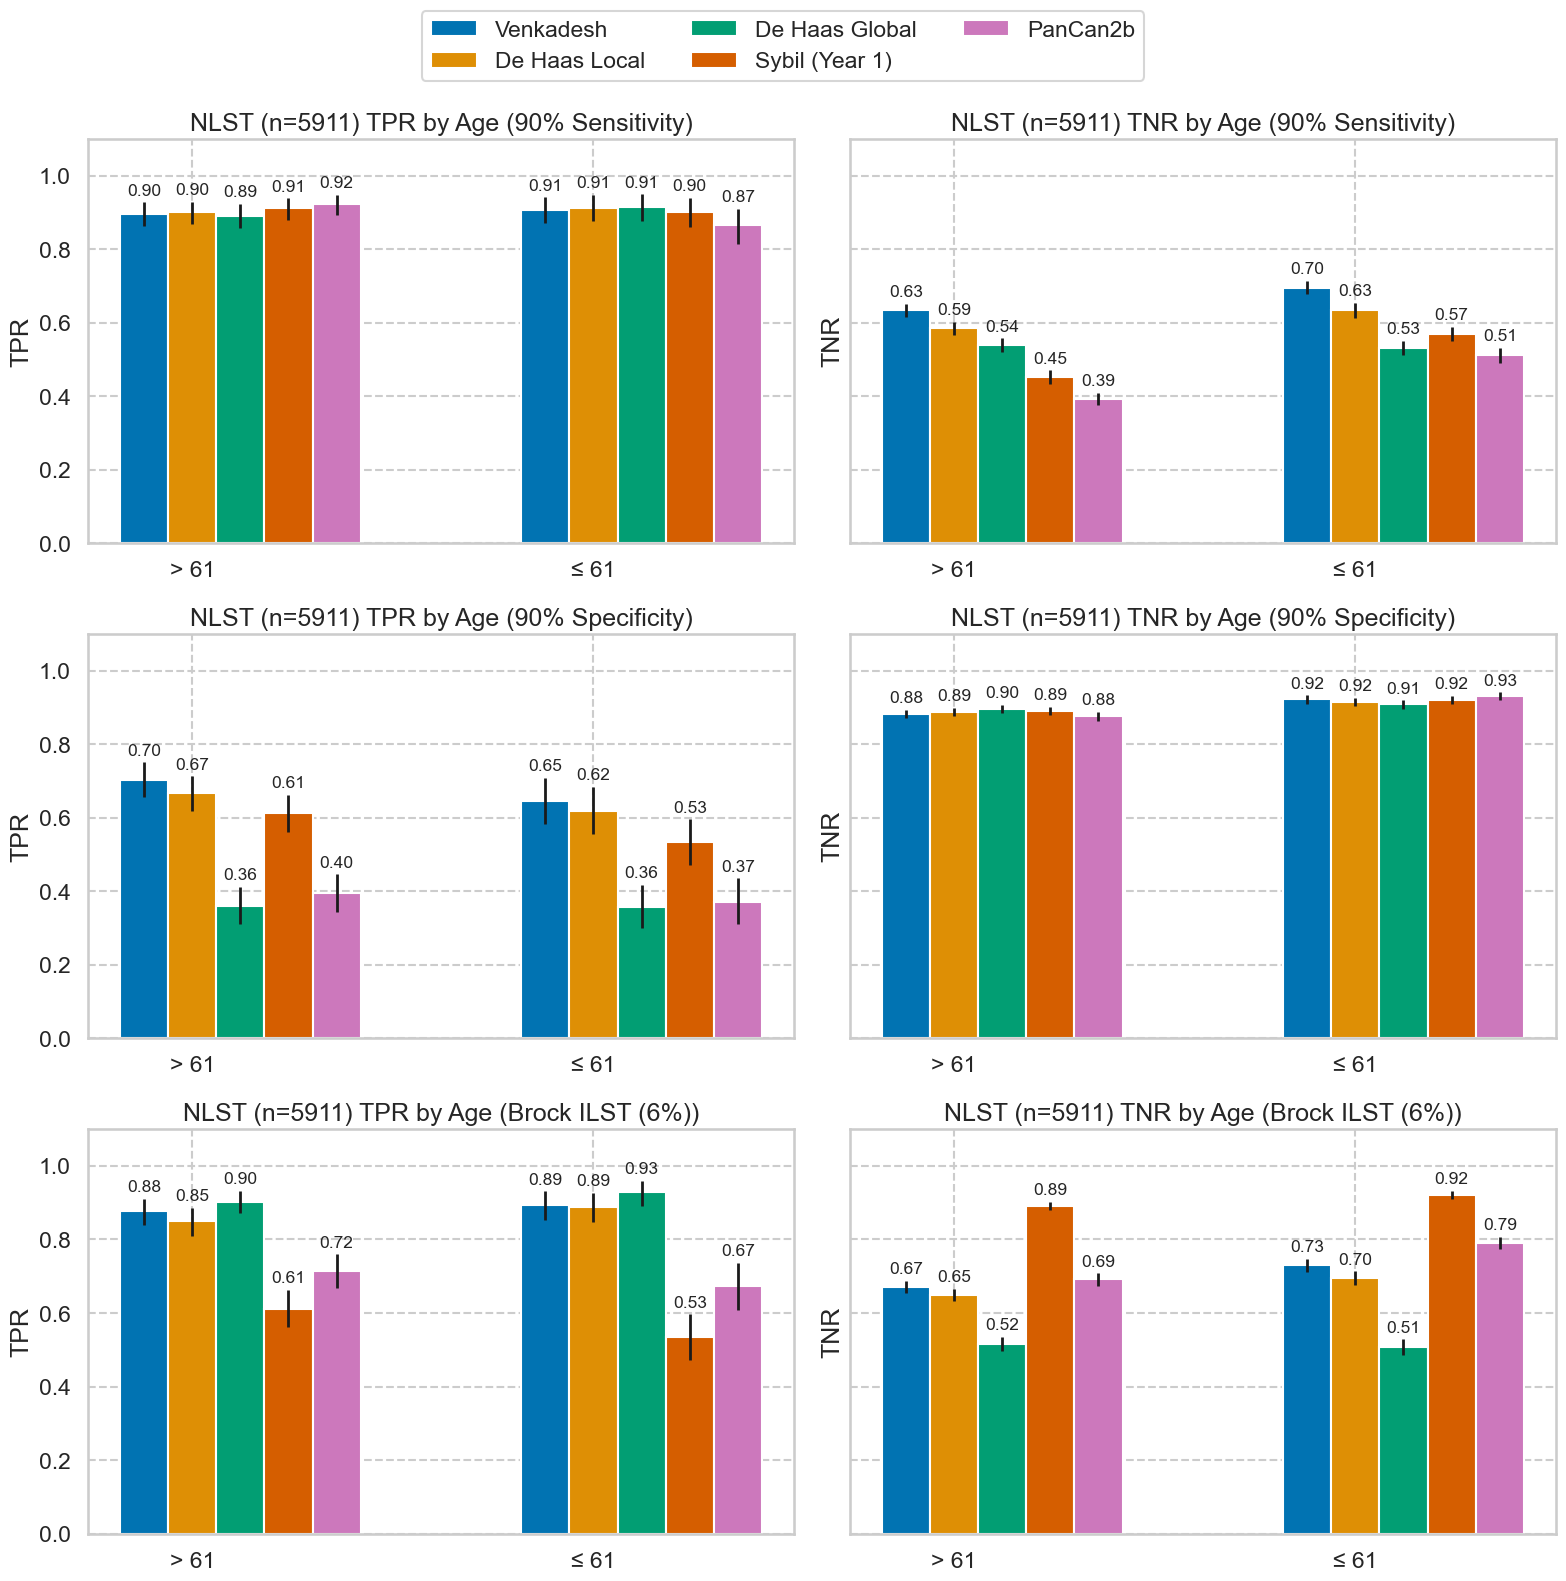

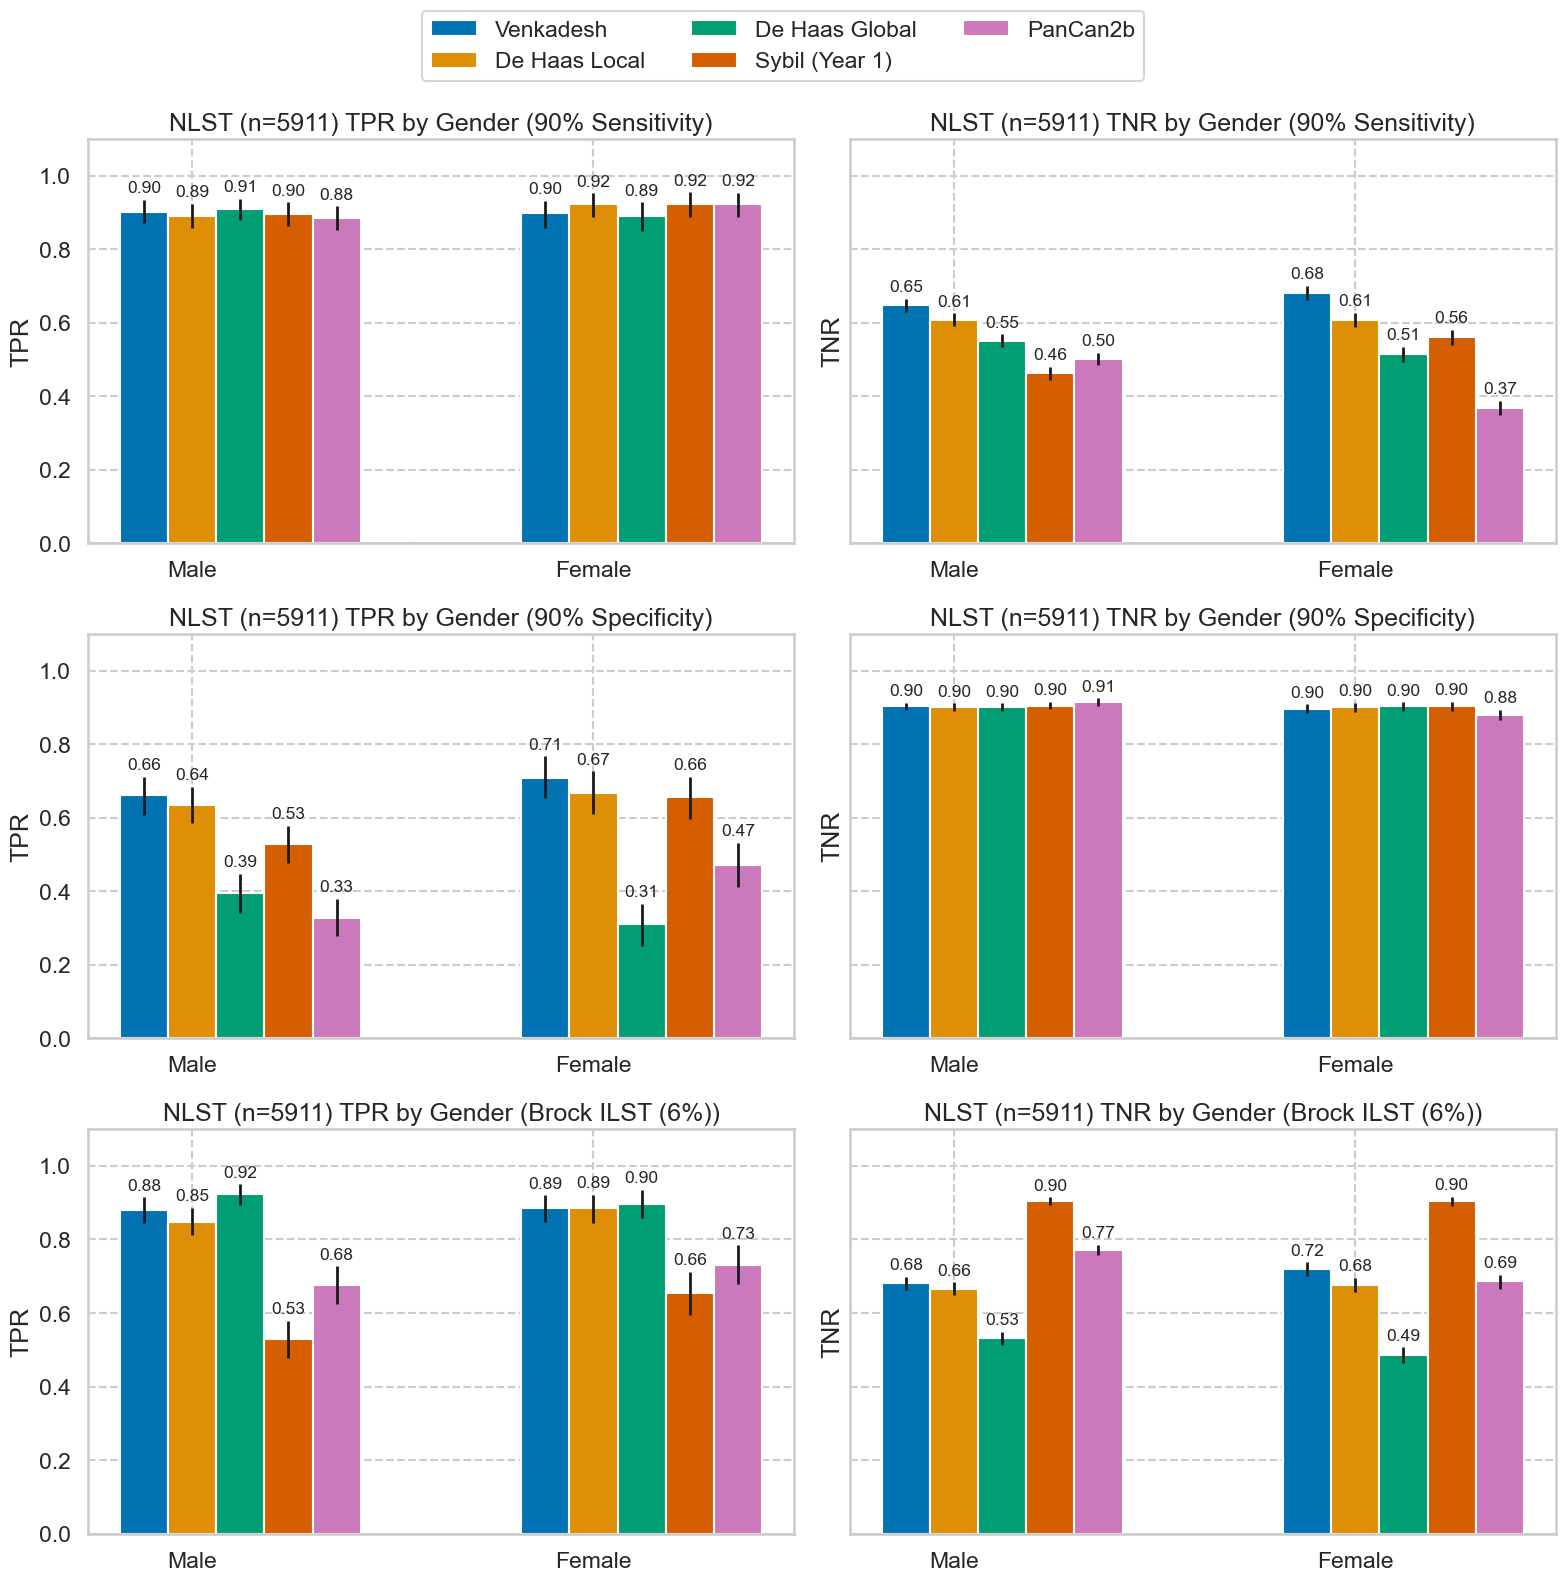

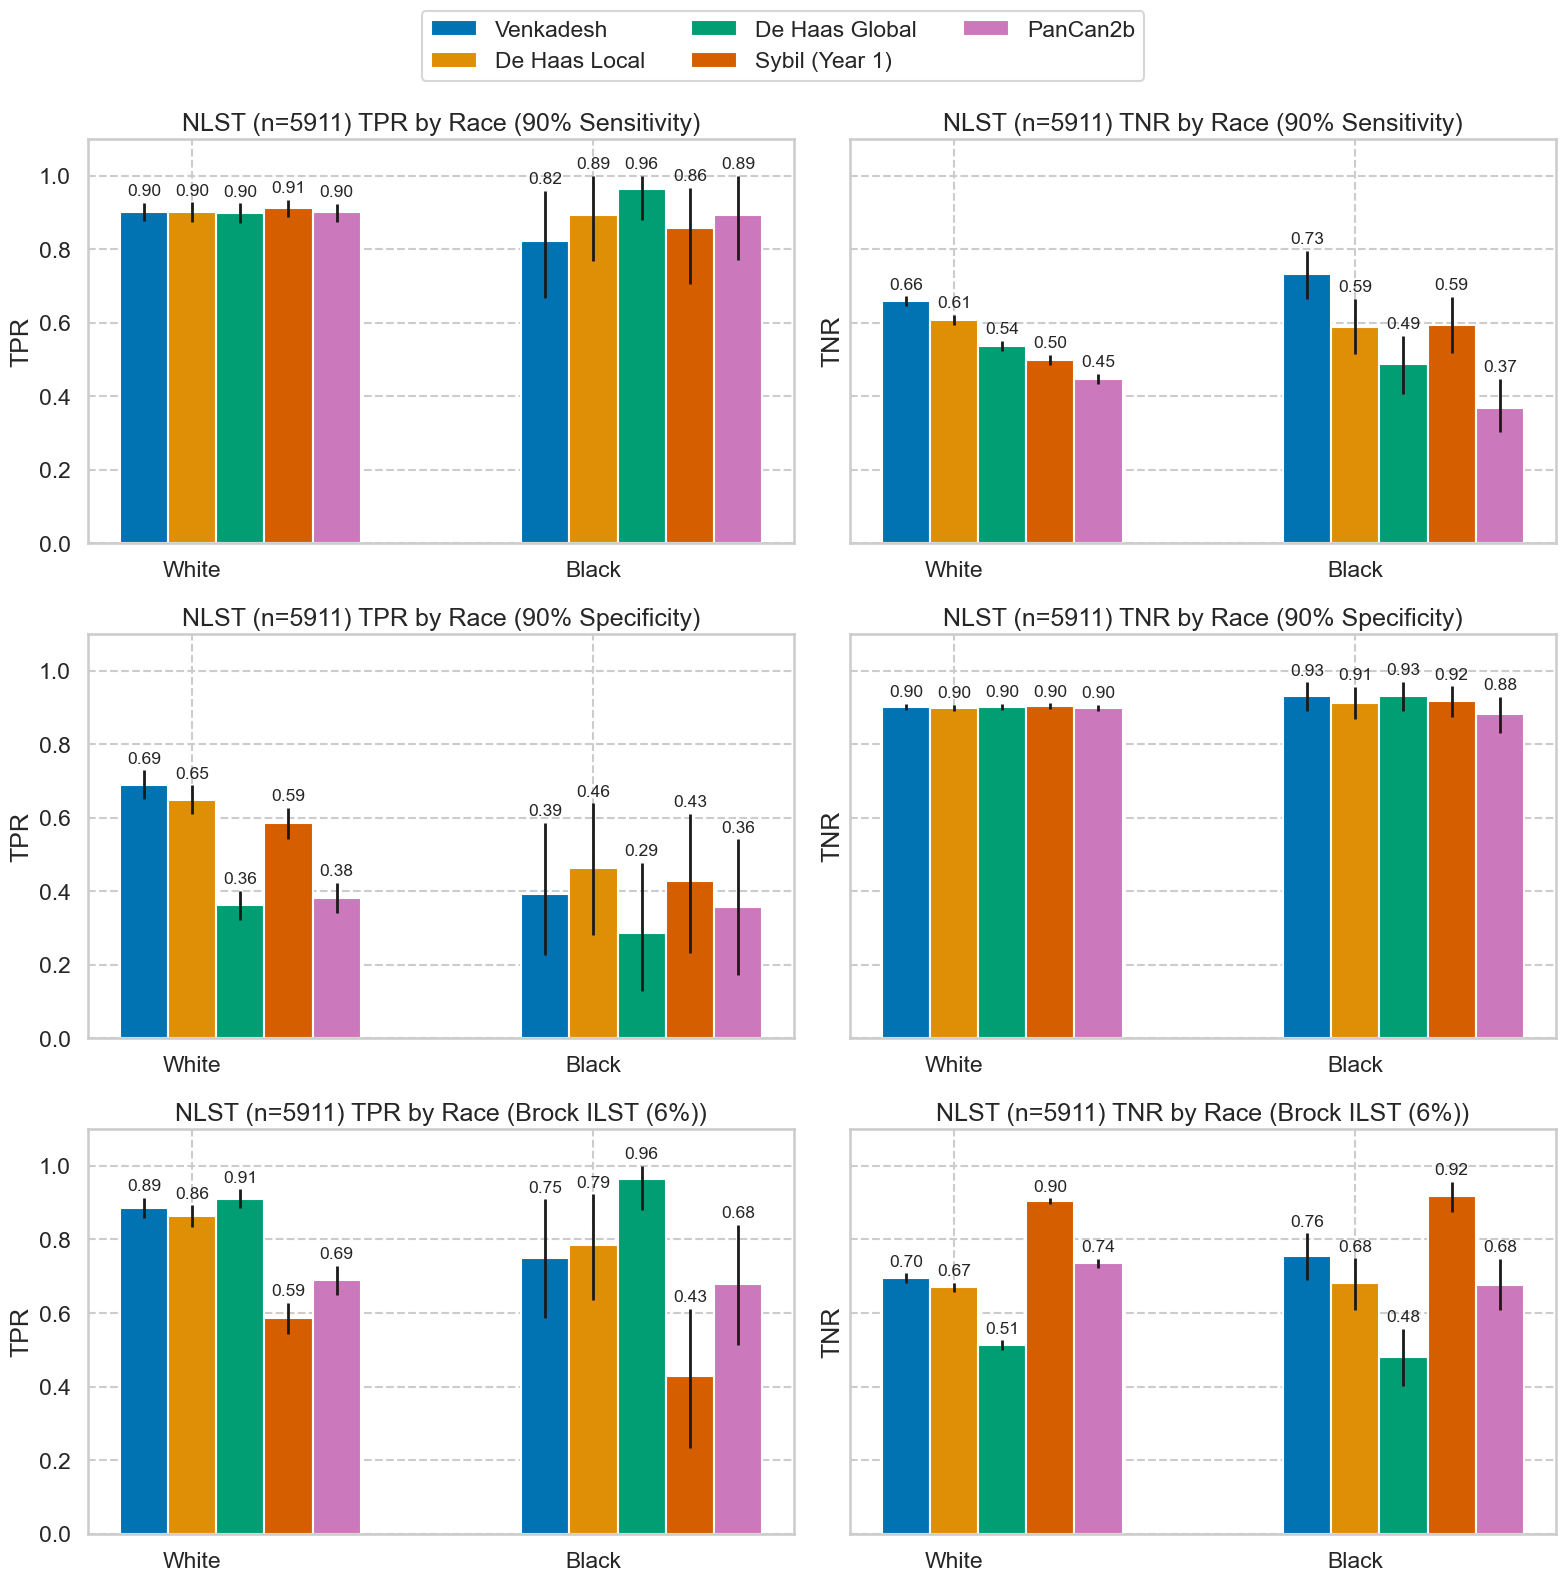

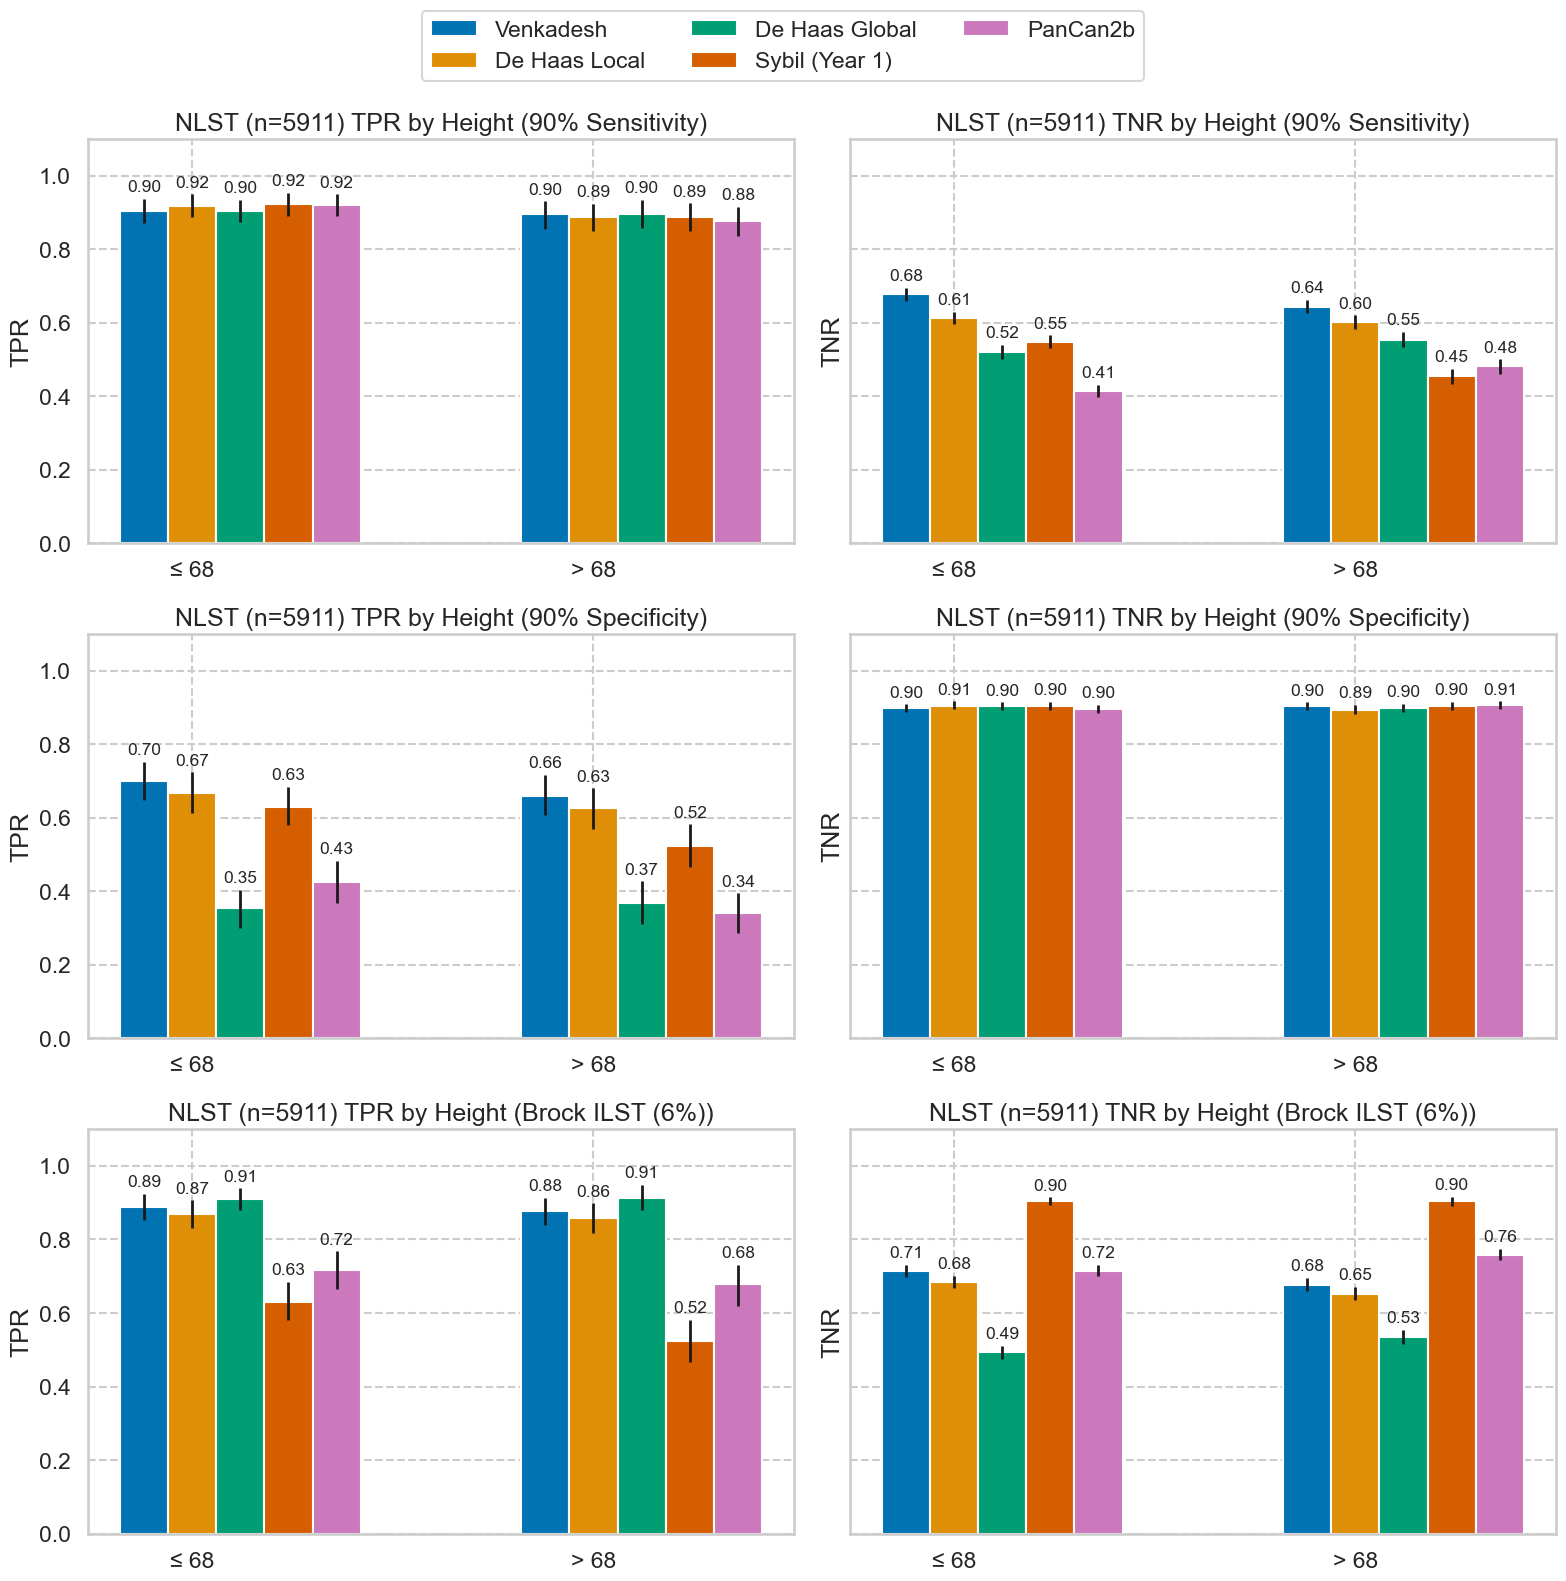

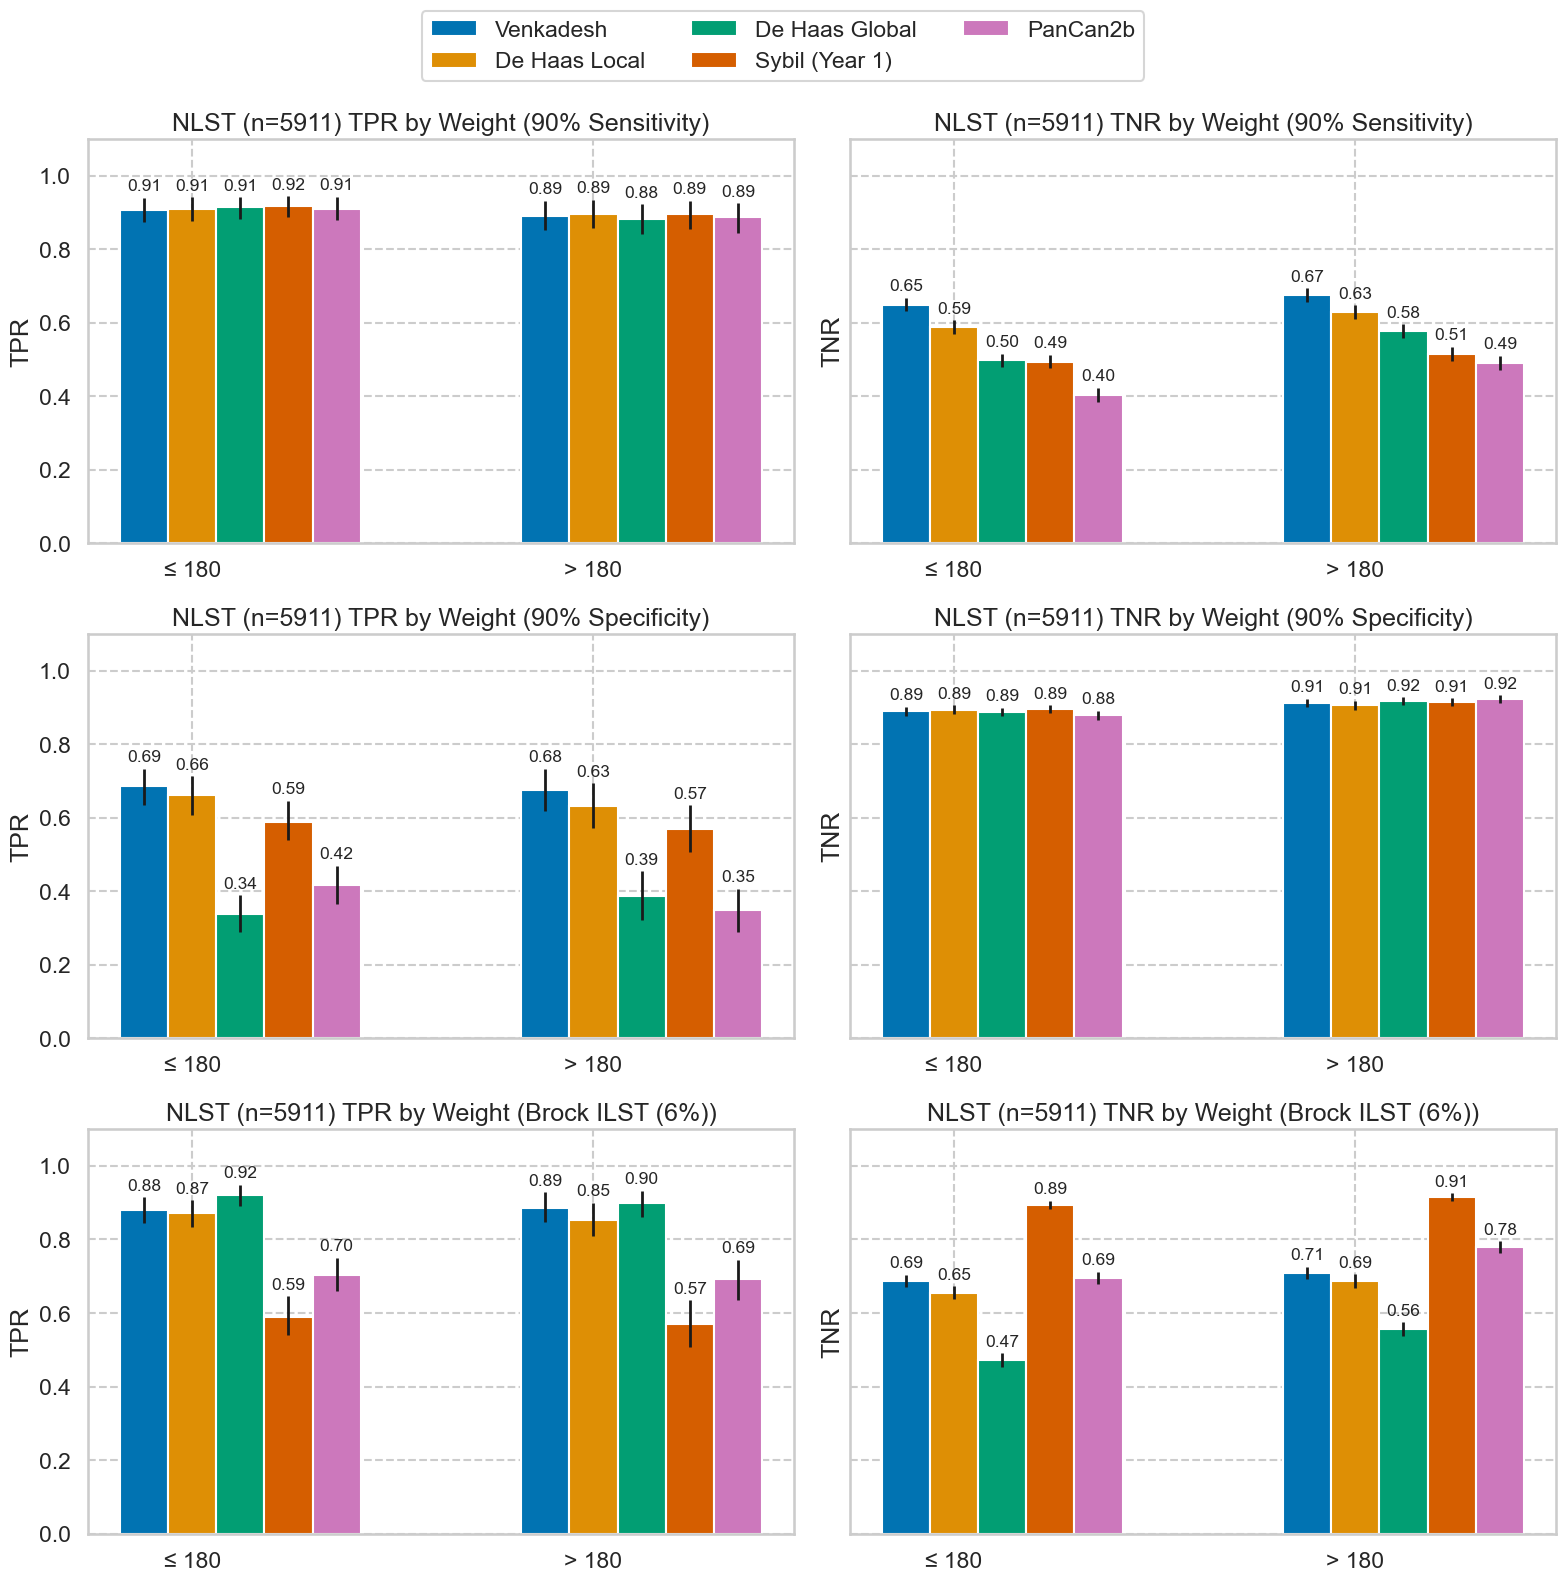

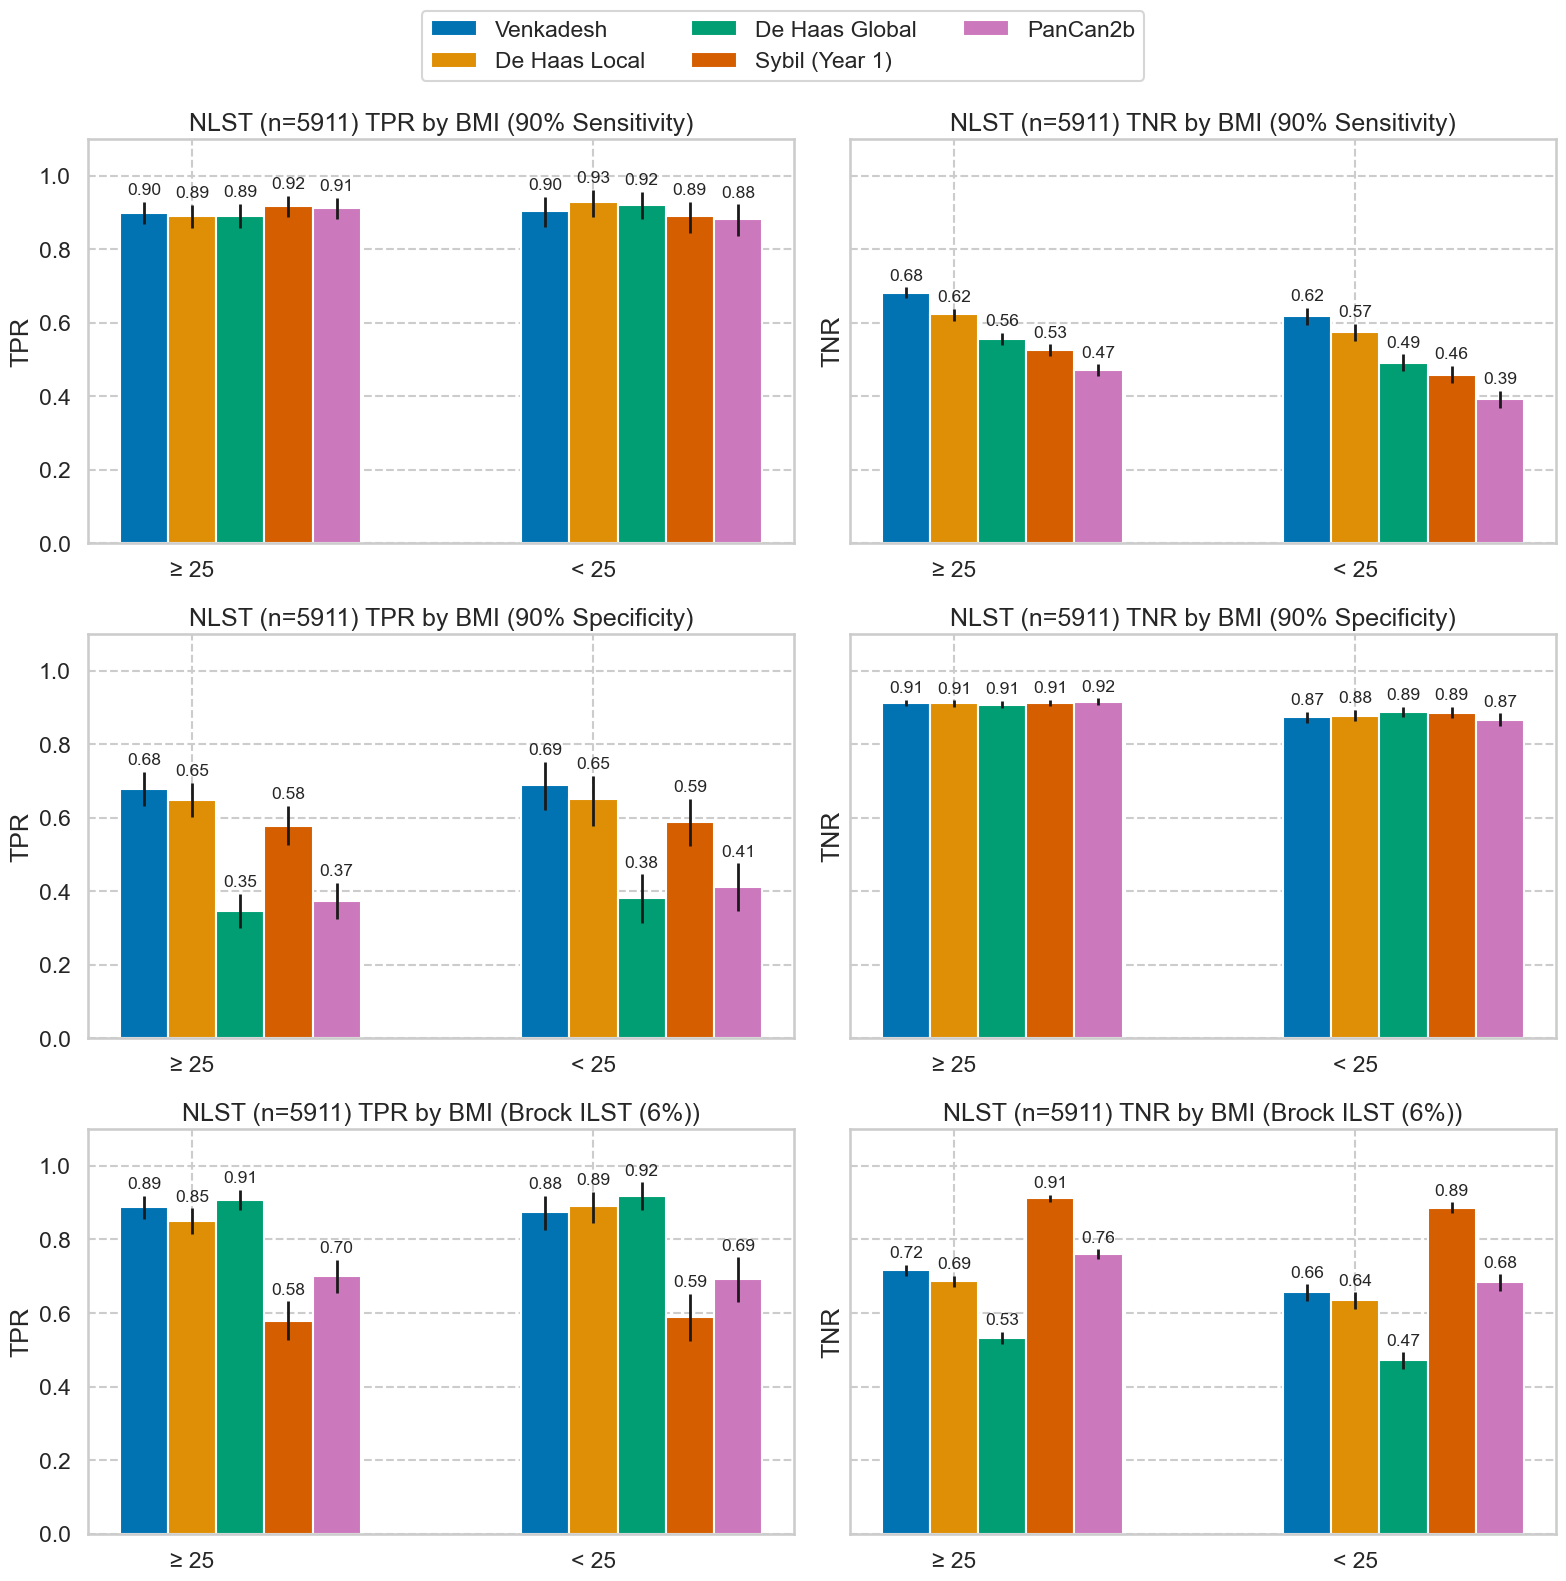

In [38]:
print(nlst_demos_to_include)
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
                                                policies=nlst_5911_policies, models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
                                                )  

## Threshold Tables

### DLCST

In [39]:
dlcst_demos_to_include = ['Age', 'Gender']
pairwise_tpr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric="TPR")
threshold_tpr_dlcst = output.threshold_results_pretty(pairwise_tpr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='TPR')
tpr_dlcst_demo = threshold_tpr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tpr_dlcst_demo

Venkadesh      De Haas Combined      \
                                                TPR CI                TPR  CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.94 (0.84, 1.00)     0.87 (0.76, 0.97)       
                          ≤ 61    0.89 (0.77, 1.00)     0.96 (0.88, 1.00)       
                Gender    Male    0.88 (0.75, 1.00)     0.84 (0.70, 0.96)       
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)  **   
90% Specificity Age       > 61    0.84 (0.70, 0.96)     0.81 (0.67, 0.94)       
                          ≤ 61    0.71 (0.55, 0.88)     0.75 (0.58, 0.90)       
                Gender    Male    0.78 (0.64, 0.93)     0.75 (0.59, 0.90)       
                          Female  0.78 (0.62, 0.93)     0.81 (0.67, 0.96)       
Brock ILST (6%) Age       > 61    0.94 (0.84, 1.00)     0.94 (0.84, 1.00)       
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)       
                Gender    Male    0.91 (0.79, 1.00)     0.91 (0.79, 1.00)       
                          Female  1.00 (1.00, 1.00)     1.00 (1.00, 1.00)       

                                           PanCan2b        Sybil (Year 1)     
                                                TPR CI                TPR CI  
Policy          Attribute Group                                               
90% Sensitivity Age       > 61    0.87 (0.75, 0.97)     0.97 (0.89, 1.00)     
                          ≤ 61    0.96 (0.88, 1.00)     0.96 (0.88, 1.00)     
                Gender    Male    0.88 (0.75, 0.97)     0.94 (0.84, 1.00)     
                          Female  0.96 (0.88, 1.00)     1.00 (1.00, 1.00)     
90% Specificity Age       > 61    0.71 (0.54, 0.87)     0.71 (0.55, 0.86)     
                          ≤ 61    0.61 (0.43, 0.79)     0.61 (0.42, 0.77)     
                Gender    Male    0.66 (0.48, 0.82)     0.72 (0.56, 0.88)     
                          Female  0.67 (0.48, 0.84)     0.59 (0.41, 0.78)     
Brock ILST (6%) Age       > 61    0.71 (0.54, 0.87)     0.65 (0.48, 0.82)     
                          ≤ 61    0.68 (0.50, 0.85)     0.39 (0.22, 0.57)  *  
                Gender    Male    0.69 (0.52, 0.85)     0.56 (0.39, 0.73)     
                          Female  0.70 (0.52, 0.88)     0.48 (0.30, 0.68)

In [40]:
print(tpr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTPR.tex",
    hrules=True, label='tab:resDLCSTdemoTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [41]:
pairwise_tnr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='TNR')
threshold_tnr_dlcst = output.threshold_results_pretty(pairwise_tnr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='TNR')
tnr_dlcst_demo = threshold_tnr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tnr_dlcst_demo

Venkadesh       De Haas Combined     \
                                                TNR  CI                TNR CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.83 (0.77, 0.89)      0.77 (0.70, 0.84)      
                          ≤ 61    0.87 (0.83, 0.90)      0.78 (0.74, 0.82)      
                Gender    Male    0.88 (0.84, 0.92)      0.81 (0.76, 0.85)      
                          Female  0.83 (0.78, 0.87)   *  0.75 (0.69, 0.80)  *   
90% Specificity Age       > 61    0.86 (0.81, 0.92)      0.85 (0.79, 0.91)      
                          ≤ 61    0.91 (0.88, 0.94)      0.92 (0.89, 0.94)  *   
                Gender    Male    0.92 (0.89, 0.95)      0.90 (0.87, 0.93)      
                          Female  0.88 (0.83, 0.91)   *  0.90 (0.86, 0.93)      
Brock ILST (6%) Age       > 61    0.69 (0.61, 0.76)      0.68 (0.59, 0.75)      
                          ≤ 61    0.73 (0.68, 0.78)      0.67 (0.62, 0.72)      
                Gender    Male    0.77 (0.72, 0.82)      0.70 (0.64, 0.75)      
                          Female  0.66 (0.60, 0.72)  **  0.64 (0.59, 0.70)      

                                           PanCan2b         Sybil (Year 1)     
                                                TNR  CI                TNR CI  
Policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.65 (0.57, 0.73)      0.13 (0.08, 0.18)     
                          ≤ 61    0.72 (0.68, 0.76)      0.17 (0.14, 0.21)     
                Gender    Male    0.78 (0.74, 0.83)      0.16 (0.13, 0.21)     
                          Female  0.61 (0.55, 0.66)  **  0.16 (0.11, 0.20)     
90% Specificity Age       > 61    0.84 (0.78, 0.90)      0.86 (0.80, 0.92)     
                          ≤ 61    0.92 (0.89, 0.95)   *  0.93 (0.90, 0.95)  *  
                Gender    Male    0.93 (0.90, 0.96)      0.93 (0.90, 0.96)     
                          Female  0.86 (0.81, 0.90)  **  0.89 (0.85, 0.92)  *  
Brock ILST (6%) Age       > 61    0.80 (0.73, 0.86)      0.93 (0.89, 0.97)     
                          ≤ 61    0.86 (0.83, 0.90)   *  0.96 (0.94, 0.98)     
                Gender    Male    0.89 (0.86, 0.92)      0.95 (0.92, 0.97)     
                          Female  0.80 (0.74, 0.84)  **  0.96 (0.93, 0.98)

In [42]:
print(tnr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTNR.tex",
    hrules=True, label='tab:resDLCSTdemoTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the DLCST validation set (n=599 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 1172

In [43]:
pairwise_tpr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric="TPR")
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_1172, model_order=list(output.NLST_1172_MODELCOLS.keys()), metric='TPR')

In [44]:
tpr_demo_1172 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tpr_demo_1172 = tpr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tpr_demo_1172

De Haas Combined         De Haas Local     \
                                                TPR CI                TPR CI   
Policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.90 (0.82, 0.96)     0.90 (0.83, 0.96)      
                          ≤ 61    0.92 (0.83, 0.98)     0.92 (0.83, 0.98)      
                BMI       ≥ 25    0.89 (0.82, 0.95)     0.90 (0.84, 0.96)      
                          < 25    0.93 (0.86, 1.00)     0.91 (0.82, 0.98)      
                Gender    Male    0.91 (0.84, 0.97)     0.91 (0.84, 0.97)      
                          Female  0.90 (0.80, 0.98)     0.90 (0.80, 0.98)      
                Height    > 68    0.90 (0.82, 0.97)     0.90 (0.83, 0.97)      
                          ≤ 68    0.91 (0.83, 0.98)     0.91 (0.84, 0.98)      
                Weight    ≤ 180   0.89 (0.81, 0.96)     0.89 (0.81, 0.96)      
                          > 180   0.93 (0.86, 0.98)     0.93 (0.86, 0.98)      
90% Specificity Age       > 61    0.60 (0.49, 0.72)     0.64 (0.53, 0.74)      
                          ≤ 61    0.67 (0.53, 0.80)     0.63 (0.49, 0.76)      
                BMI       ≥ 25    0.61 (0.51, 0.71)     0.62 (0.52, 0.72)      
                          < 25    0.67 (0.53, 0.80)     0.67 (0.52, 0.80)      
                Gender    Male    0.59 (0.48, 0.71)     0.61 (0.50, 0.72)      
                          Female  0.69 (0.56, 0.82)     0.69 (0.55, 0.82)      
                Height    > 68    0.60 (0.48, 0.71)     0.59 (0.47, 0.70)      
                          ≤ 68    0.67 (0.54, 0.79)     0.70 (0.59, 0.82)      
                Weight    ≤ 180   0.68 (0.58, 0.79)     0.67 (0.56, 0.78)      
                          > 180   0.56 (0.42, 0.69)     0.59 (0.46, 0.72)      
Brock ILST (6%) Age       > 61    0.90 (0.82, 0.96)     0.85 (0.76, 0.92)      
                          ≤ 61    0.92 (0.83, 0.98)     0.90 (0.80, 0.98)      
                BMI       ≥ 25    0.89 (0.82, 0.95)     0.88 (0.81, 0.95)      
                          < 25    0.93 (0.86, 1.00)     0.84 (0.73, 0.94)      
                Gender    Male    0.91 (0.84, 0.97)     0.87 (0.79, 0.94)      
                          Female  0.90 (0.80, 0.98)     0.85 (0.75, 0.94)      
                Height    > 68    0.90 (0.82, 0.97)     0.87 (0.79, 0.95)      
                          ≤ 68    0.91 (0.83, 0.98)     0.86 (0.77, 0.95)      
                Weight    ≤ 180   0.89 (0.81, 0.96)     0.85 (0.76, 0.93)      
                          > 180   0.93 (0.86, 0.98)     0.89 (0.80, 0.97)      

                                     De Haas Global     
                                                TPR CI  
Policy          Attribute Group                         
90% Sensitivity Age       > 61    0.87 (0.79, 0.94)     
                          ≤ 61    0.96 (0.89, 1.00)  *  
                BMI       ≥ 25    0.89 (0.82, 0.95)     
                          < 25    0.93 (0.85, 1.00)     
                Gender    Male    0.92 (0.86, 0.98)     
                          Female  0.88 (0.77, 0.96)     
                Height    > 68    0.91 (0.84, 0.97)     
                          ≤ 68    0.89 (0.81, 0.96)     
                Weight    ≤ 180   0.92 (0.85, 0.97)     
                          > 180   0.89 (0.80, 0.96)     
90% Specificity Age       > 61    0.29 (0.20, 0.40)     
                          ≤ 61    0.31 (0.17, 0.45)     
                BMI       ≥ 25    0.28 (0.19, 0.38)     
                          < 25    0.33 (0.20, 0.47)     
                Gender    Male    0.34 (0.24, 0.45)     
                          Female  0.23 (0.12, 0.35)     
                Height    > 68    0.31 (0.21, 0.42)     
                          ≤ 68    0.28 (0.17, 0.40)     
                Weight    ≤ 180   0.26 (0.16, 0.36)     
                          > 180   0.35 (0.23, 0.48)     
Brock ILST (6%) Age       > 61    0.87 (0.79, 0.94)     
                          

In [45]:
print(tpr_demo_1172.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTPR.tex",
    hrules=True, label='tab:resNLSTtijmenTPR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [46]:
pairwise_tnr_1172 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_1172, metric='TNR')
tnr_1172 = output.threshold_results_pretty(pairwise_tnr_1172, model_order=list(output.NLST_1172_MODELCOLS.keys()), metric='TNR')
tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')

De Haas Combined          De Haas Local     \
                                                TNR  CI                TNR CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.62 (0.58, 0.66)      0.60 (0.56, 0.64)      
                          ≤ 61    0.65 (0.61, 0.69)      0.63 (0.59, 0.67)      
                BMI       ≥ 25    0.66 (0.63, 0.70)      0.64 (0.60, 0.67)      
                          < 25    0.57 (0.52, 0.62)  **  0.56 (0.51, 0.61)  *   
                Gender    Male    0.66 (0.63, 0.70)      0.62 (0.58, 0.66)      
                          Female  0.60 (0.55, 0.64)   *  0.60 (0.55, 0.64)      
                Height    > 68    0.66 (0.62, 0.70)      0.62 (0.57, 0.66)      
                          ≤ 68    0.61 (0.57, 0.65)   *  0.61 (0.57, 0.64)      
                Weight    ≤ 180   0.59 (0.56, 0.64)      0.60 (0.56, 0.64)      
                          > 180   0.68 (0.63, 0.72)   *  0.62 (0.58, 0.67)      
90% Specificity Age       > 61    0.91 (0.89, 0.94)      0.89 (0.86, 0.91)      
                          ≤ 61    0.88 (0.85, 0.91)   *  0.92 (0.90, 0.95)  *   
                BMI       ≥ 25    0.91 (0.88, 0.93)      0.92 (0.90, 0.94)      
                          < 25    0.89 (0.85, 0.92)      0.87 (0.83, 0.90)  *   
                Gender    Male    0.90 (0.88, 0.93)      0.91 (0.89, 0.93)      
                          Female  0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                Height    > 68    0.90 (0.87, 0.93)      0.92 (0.89, 0.94)      
                          ≤ 68    0.90 (0.87, 0.93)      0.89 (0.86, 0.91)  *   
                Weight    ≤ 180   0.89 (0.86, 0.91)      0.89 (0.86, 0.91)      
                          > 180   0.91 (0.89, 0.94)   *  0.91 (0.89, 0.94)      
Brock ILST (6%) Age       > 61    0.61 (0.57, 0.64)      0.64 (0.60, 0.67)      
                          ≤ 61    0.62 (0.57, 0.66)      0.67 (0.62, 0.71)      
                BMI       ≥ 25    0.64 (0.60, 0.68)      0.68 (0.64, 0.71)      
                          < 25    0.54 (0.49, 0.60)  **  0.59 (0.54, 0.64)  *   
                Gender    Male    0.64 (0.60, 0.67)      0.66 (0.62, 0.69)      
                          Female  0.57 (0.52, 0.62)   *  0.63 (0.59, 0.68)      
                Height    > 68    0.63 (0.59, 0.68)      0.66 (0.61, 0.70)      
                          ≤ 68    0.59 (0.55, 0.63)      0.64 (0.60, 0.68)      
                Weight    ≤ 180   0.57 (0.54, 0.62)      0.64 (0.60, 0.68)      
                          > 180   0.65 (0.61, 0.69)   *  0.66 (0.62, 0.70)      

                                     De Haas Global      
                                                TNR  CI  
Policy          Attribute Group                          
90% Sensitivity Age       > 61    0.54 (0.50, 0.58)      
                          ≤ 61    0.49 (0.44, 0.53)   *  
                BMI       ≥ 25    0.55 (0.51, 0.58)      
                          < 25    0.45 (0.40, 0.50)  **  
                Gender    Male    0.55 (0.51, 0.59)      
                          Female  0.47 (0.42, 0.52)   *  
                Height    > 68    0.56 (0.52, 0.61)      
                          ≤ 68    0.47 (0.43, 0.51)  **  
                Weight    ≤ 180   0.46 (0.41, 0.50)      
                          > 180   0.58 (0.53, 0.62)  **  
90% Specificity Age       > 61    0.91 (0.88, 0.93)      
                          ≤ 61    0.89 (0.86, 0.92)      
                BMI       ≥ 25    0.91 (0.89, 0.93)      
                          < 25    0.88 (0.85, 0.92)      
                Gender    Male    0.90 (0.88, 0.92)      
                          Female  0.90 (0.87, 0.93)      
                Height    > 68    0.90 (0.87, 0.93)      
                          ≤ 68    0.90 (0.88, 0.92)      
                Weight    ≤ 180   0.89 (0.87, 0.92)      
                          > 180   0.91 (0.88, 0.93)      
Brock ILST (6%) Age       >

In [47]:
tnr_demo_1172 = tnr_1172.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_1172')
tnr_demo_1172 = tnr_demo_1172[['De Haas Combined', 'De Haas Local', 'De Haas Global']]
tnr_demo_1172

De Haas Combined          De Haas Local     \
                                                TNR  CI                TNR CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.62 (0.58, 0.66)      0.60 (0.56, 0.64)      
                          ≤ 61    0.65 (0.61, 0.69)      0.63 (0.59, 0.67)      
                BMI       ≥ 25    0.66 (0.63, 0.70)      0.64 (0.60, 0.67)      
                          < 25    0.57 (0.52, 0.62)  **  0.56 (0.51, 0.61)  *   
                Gender    Male    0.66 (0.63, 0.70)      0.62 (0.58, 0.66)      
                          Female  0.60 (0.55, 0.64)   *  0.60 (0.55, 0.64)      
                Height    > 68    0.66 (0.62, 0.70)      0.62 (0.57, 0.66)      
                          ≤ 68    0.61 (0.57, 0.65)   *  0.61 (0.57, 0.64)      
                Weight    ≤ 180   0.59 (0.56, 0.64)      0.60 (0.56, 0.64)      
                          > 180   0.68 (0.63, 0.72)   *  0.62 (0.58, 0.67)      
90% Specificity Age       > 61    0.91 (0.89, 0.94)      0.89 (0.86, 0.91)      
                          ≤ 61    0.88 (0.85, 0.91)   *  0.92 (0.90, 0.95)  *   
                BMI       ≥ 25    0.91 (0.88, 0.93)      0.92 (0.90, 0.94)      
                          < 25    0.89 (0.85, 0.92)      0.87 (0.83, 0.90)  *   
                Gender    Male    0.90 (0.88, 0.93)      0.91 (0.89, 0.93)      
                          Female  0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                Height    > 68    0.90 (0.87, 0.93)      0.92 (0.89, 0.94)      
                          ≤ 68    0.90 (0.87, 0.93)      0.89 (0.86, 0.91)  *   
                Weight    ≤ 180   0.89 (0.86, 0.91)      0.89 (0.86, 0.91)      
                          > 180   0.91 (0.89, 0.94)   *  0.91 (0.89, 0.94)      
Brock ILST (6%) Age       > 61    0.61 (0.57, 0.64)      0.64 (0.60, 0.67)      
                          ≤ 61    0.62 (0.57, 0.66)      0.67 (0.62, 0.71)      
                BMI       ≥ 25    0.64 (0.60, 0.68)      0.68 (0.64, 0.71)      
                          < 25    0.54 (0.49, 0.60)  **  0.59 (0.54, 0.64)  *   
                Gender    Male    0.64 (0.60, 0.67)      0.66 (0.62, 0.69)      
                          Female  0.57 (0.52, 0.62)   *  0.63 (0.59, 0.68)      
                Height    > 68    0.63 (0.59, 0.68)      0.66 (0.61, 0.70)      
                          ≤ 68    0.59 (0.55, 0.63)      0.64 (0.60, 0.68)      
                Weight    ≤ 180   0.57 (0.54, 0.62)      0.64 (0.60, 0.68)      
                          > 180   0.65 (0.61, 0.69)   *  0.66 (0.62, 0.70)      

                                     De Haas Global      
                                                TNR  CI  
Policy          Attribute Group                          
90% Sensitivity Age       > 61    0.54 (0.50, 0.58)      
                          ≤ 61    0.49 (0.44, 0.53)   *  
                BMI       ≥ 25    0.55 (0.51, 0.58)      
                          < 25    0.45 (0.40, 0.50)  **  
                Gender    Male    0.55 (0.51, 0.59)      
                          Female  0.47 (0.42, 0.52)   *  
                Height    > 68    0.56 (0.52, 0.61)      
                          ≤ 68    0.47 (0.43, 0.51)  **  
                Weight    ≤ 180   0.46 (0.41, 0.50)      
                          > 180   0.58 (0.53, 0.62)  **  
90% Specificity Age       > 61    0.91 (0.88, 0.93)      
                          ≤ 61    0.89 (0.86, 0.92)      
                BMI       ≥ 25    0.91 (0.89, 0.93)      
                          < 25    0.88 (0.85, 0.92)      
                Gender    Male    0.90 (0.88, 0.92)      
                          Female  0.90 (0.87, 0.93)      
                Height    > 68    0.90 (0.87, 0.93)      
                          ≤ 68    0.90 (0.88, 0.92)      
                Weight    ≤ 180   0.89 (0.87, 0.92)      
                          > 180   0.91 (0.88, 0.93)      
Brock ILST (6%) Age       >

In [48]:
print(tnr_demo_1172.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenTNR.tex",
    hrules=True, label='tab:resNLSTtijmenTNR', environment='table*', column_format=f'lll{"|ll"*3}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for the De Haas Combined model and its submodels on demographic characteristics when evaluated on the partial NLST validation set (n=1172 scans). Race and High School Education analysis are not included since there are less than 15 malignant scans in the underrepresented subgroup. Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 5911

In [49]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TPR")
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='TPR')
tpr_demo_5911 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tpr_demo_5911

Venkadesh          De Haas Local     \
                                                TPR  CI                TPR CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.90 (0.86, 0.93)      0.90 (0.87, 0.93)      
                          ≤ 61    0.91 (0.87, 0.94)      0.91 (0.88, 0.95)      
                BMI       ≥ 25    0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                          < 25    0.90 (0.86, 0.94)      0.93 (0.89, 0.96)      
                Gender    Male    0.90 (0.87, 0.93)      0.89 (0.86, 0.92)      
                          Female  0.90 (0.86, 0.93)      0.92 (0.89, 0.95)      
                Height    ≤ 68    0.90 (0.87, 0.94)      0.92 (0.89, 0.95)      
                          > 68    0.90 (0.85, 0.93)      0.89 (0.85, 0.92)      
                Race      White   0.90 (0.88, 0.93)      0.90 (0.87, 0.93)      
                          Black   0.82 (0.67, 0.96)      0.89 (0.77, 1.00)      
                Weight    ≤ 180   0.91 (0.87, 0.94)      0.91 (0.88, 0.94)      
                          > 180   0.89 (0.85, 0.93)      0.89 (0.86, 0.93)      
90% Specificity Age       > 61    0.70 (0.66, 0.75)      0.67 (0.62, 0.71)      
                          ≤ 61    0.65 (0.58, 0.71)      0.62 (0.56, 0.68)      
                BMI       ≥ 25    0.68 (0.63, 0.72)      0.65 (0.60, 0.70)      
                          < 25    0.69 (0.62, 0.75)      0.65 (0.58, 0.71)      
                Gender    Male    0.66 (0.61, 0.71)      0.64 (0.59, 0.68)      
                          Female  0.71 (0.65, 0.77)      0.67 (0.61, 0.73)      
                Height    ≤ 68    0.70 (0.65, 0.75)      0.67 (0.61, 0.72)      
                          > 68    0.66 (0.61, 0.72)      0.63 (0.57, 0.68)      
                Race      White   0.69 (0.65, 0.73)      0.65 (0.61, 0.69)      
                          Black   0.39 (0.23, 0.59)  **  0.46 (0.28, 0.64)  *   
                Weight    ≤ 180   0.69 (0.64, 0.73)      0.66 (0.61, 0.71)      
                          > 180   0.68 (0.62, 0.73)      0.63 (0.57, 0.69)      
Brock ILST (6%) Age       > 61    0.88 (0.84, 0.91)      0.85 (0.81, 0.89)      
                          ≤ 61    0.89 (0.85, 0.93)      0.89 (0.85, 0.93)      
                BMI       ≥ 25    0.89 (0.86, 0.92)      0.85 (0.81, 0.88)      
                          < 25    0.88 (0.83, 0.92)      0.89 (0.84, 0.93)      
                Gender    Male    0.88 (0.85, 0.91)      0.85 (0.81, 0.89)      
                          Female  0.89 (0.85, 0.92)      0.89 (0.84, 0.92)      
                Height    ≤ 68    0.89 (0.85, 0.92)      0.87 (0.83, 0.91)      
                          > 68    0.88 (0.84, 0.91)      0.86 (0.82, 0.90)      
                Race      White   0.89 (0.86, 0.91)      0.86 (0.83, 0.89)      
                          Black   0.75 (0.59, 0.91)      0.79 (0.64, 0.92)      
                Weight    ≤ 180   0.88 (0.84, 0.91)      0.87 (0.83, 0.91)      
                          > 180   0.89 (0.85, 0.93)      0.85 (0.81, 0.90)      

                                     De Haas Global        Sybil (Year 1)      \
                                                TPR CI                TPR  CI   
Policy          Attribute Group                                                 
90% Sensitivity Age       > 61    0.89 (0.86, 0.92)     0.91 (0.88, 0.94)       
                          ≤ 61    0.91 (0.88, 0.95)     0.90 (0.86, 0.94)       
                BMI       ≥ 25    0.89 (0.86, 0.92)     0.92 (0.89, 0.95)       
                          < 25    0.92 (0.88, 0.96)     0.89 (0.84, 0.93)       
                Gender    Male    0.91 (0.88, 0.94)     0.90 (0.86, 0.93)       
                          Female  0.89 (0.85, 0.93)     0.92 (0.89, 0.95)       
                Height    ≤ 68    0.90 (0.87, 0.93)     0.92 (0.89, 0.95)       
                          > 68    0.90 (0.86, 0.93)     0.89 (0.85, 0.92

In [50]:
print(tpr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTPR.tex",
    hrules=True, label='tab:resNLSTfullTPR', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (TPR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TPR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [51]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric="TNR")
threshold_tnr = output.threshold_results_pretty(pairwise_tnr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='TNR')
tnr_demo_5911 = threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tnr_demo_5911

Venkadesh          De Haas Local  \
                                                TNR  CI                TNR   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.63 (0.62, 0.65)      0.59 (0.57, 0.60)   
                          ≤ 61    0.70 (0.68, 0.71)  **  0.63 (0.61, 0.65)   
                BMI       ≥ 25    0.68 (0.67, 0.70)      0.62 (0.61, 0.64)   
                          < 25    0.62 (0.59, 0.64)  **  0.57 (0.55, 0.60)   
                Gender    Male    0.65 (0.63, 0.66)      0.61 (0.59, 0.63)   
                          Female  0.68 (0.66, 0.70)   *  0.61 (0.59, 0.63)   
                Height    ≤ 68    0.68 (0.66, 0.69)      0.61 (0.60, 0.63)   
                          > 68    0.64 (0.63, 0.66)   *  0.60 (0.58, 0.62)   
                Race      White   0.66 (0.65, 0.67)      0.61 (0.59, 0.62)   
                          Black   0.73 (0.66, 0.79)   *  0.59 (0.52, 0.66)   
                Weight    ≤ 180   0.65 (0.63, 0.67)      0.59 (0.57, 0.61)   
                          > 180   0.67 (0.66, 0.69)   *  0.63 (0.61, 0.65)   
90% Specificity Age       > 61    0.88 (0.87, 0.89)      0.89 (0.88, 0.90)   
                          ≤ 61    0.92 (0.91, 0.93)  **  0.92 (0.90, 0.93)   
                BMI       ≥ 25    0.91 (0.90, 0.92)      0.91 (0.90, 0.92)   
                          < 25    0.87 (0.86, 0.89)  **  0.88 (0.86, 0.89)   
                Gender    Male    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Female  0.90 (0.88, 0.91)      0.90 (0.89, 0.91)   
                Height    ≤ 68    0.90 (0.89, 0.91)      0.91 (0.89, 0.92)   
                          > 68    0.90 (0.89, 0.91)      0.89 (0.88, 0.91)   
                Race      White   0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Black   0.93 (0.89, 0.97)      0.91 (0.87, 0.96)   
                Weight    ≤ 180   0.89 (0.88, 0.90)      0.89 (0.88, 0.91)   
                          > 180   0.91 (0.90, 0.92)  **  0.91 (0.89, 0.92)   
Brock ILST (6%) Age       > 61    0.67 (0.65, 0.69)      0.65 (0.63, 0.67)   
                          ≤ 61    0.73 (0.71, 0.75)  **  0.70 (0.68, 0.71)   
                BMI       ≥ 25    0.72 (0.70, 0.73)      0.69 (0.67, 0.70)   
                          < 25    0.66 (0.63, 0.68)  **  0.64 (0.61, 0.66)   
                Gender    Male    0.68 (0.66, 0.70)      0.66 (0.65, 0.68)   
                          Female  0.72 (0.70, 0.74)  **  0.68 (0.66, 0.70)   
                Height    ≤ 68    0.71 (0.70, 0.73)      0.68 (0.67, 0.70)   
                          > 68    0.68 (0.66, 0.70)  **  0.65 (0.64, 0.67)   
                Race      White   0.70 (0.68, 0.71)      0.67 (0.66, 0.68)   
                          Black   0.76 (0.69, 0.82)      0.68 (0.61, 0.75)   
                Weight    ≤ 180   0.69 (0.67, 0.70)      0.65 (0.64, 0.67)   
                          > 180   0.71 (0.69, 0.73)   *  0.69 (0.67, 0.71)   

                                         De Haas Global      \
                                  CI                TNR  CI   
Policy          Attribute Group                               
90% Sensitivity Age       > 61        0.54 (0.52, 0.56)       
                          ≤ 61    **  0.53 (0.51, 0.55)       
                BMI       ≥ 25        0.56 (0.54, 0.57)       
                          < 25    **  0.49 (0.47, 0.51)  **   
                Gender    Male        0.55 (0.53, 0.57)       
                          Female      0.51 (0.49, 0.53)   *   
                Height    ≤ 68        0.52 (0.50, 0.54)       
                          > 68        0.55 (0.53, 0.57)   *   
                Race      White       0.54 (0.52, 0.55)       
                          Black       0.49 (0.41, 0.56)       
                Weight    ≤ 180       0.50 (0.48, 0.52)       
                          > 180   **  0.58 (0.56, 0.60)  **   
90% Specificity Age       > 61        0.90 (0.89, 0.91

In [52]:
print(tnr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTNR.tex",
    hrules=True, label='tab:resNLSTfullTNR', environment='sidewaystable*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (TNR) with 95\% Confidence Intervals (CI) for models on demographic characteristics when evaluated on the full NLST validation set (n=5911 scans). Single asterisk (*) = TNR of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


## Confounders + ROC

In [53]:
nlst_5911_v2, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=False, bin_num=True)

### Gender

In [54]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_prev_roc, gender_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Gender',
    output.NLST_POSSIBLE_CONFOUNDERS,
    gender_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(gender_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderIsolationPlusROC.tex",
    hrules=True, label='tab:genderIsolationPlusROC', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between genders, and the ROC AUC scores of the Sybil (Year 1) model between men and women, isolating for them.'))

gender_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:630: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Male                                  Female  \
                                  Mal   Ben Total %            ROC AUC    Mal   
Confounder                Subset                                                
Height                    ≤ 68     80   740    23.8  0.84 (0.79, 0.88)    234   
                          > 68    257  2364    76.2  0.80 (0.77, 0.83)     10   
Weight                    ≤ 180   126  1089    35.3  0.77 (0.72, 0.82)    208   
                          > 180   211  2015    64.7  0.83 (0.80, 0.86)     36   
Smoked Pipe               False   197  1967    62.9  0.82 (0.79, 0.85)    239   
                          True    138  1118    36.5  0.80 (0.76, 0.84)      5   
Smoked Cigars             True    102   963    31.0  0.79 (0.74, 0.83)      7   
                          False   233  2127    68.6  0.82 (0.79, 0.86)    237   
Married                   False    75   697    22.4  0.80 (0.75, 0.85)    122   
                          True    262  2407    77.6  0.81 (0.78, 0.84)    122   
Work Without Mask         True    109  1075    34.4  0.79 (0.74, 0.84)     30   
                          False   228  2029    65.6  0.82 (0.79, 0.85)    214   
Pack-Years                ≤ 55    141  1601    50.6  0.81 (0.77, 0.85)    144   
                          > 55    196  1503    49.4  0.80 (0.77, 0.84)    100   
BMI                       < 25     92   811    26.2  0.76 (0.70, 0.82)    117   
                          ≥ 25    245  2293    73.8  0.83 (0.80, 0.86)    127   
Cigarettes per Day (avg.) > 25    196  1631    53.1  0.82 (0.78, 0.85)    105   
                          ≤ 25    141  1473    46.9  0.80 (0.76, 0.84)    139   
Lived with Smoker         False    43   498    15.7  0.81 (0.74, 0.89)     21   
                          True    292  2585    83.6  0.81 (0.78, 0.84)    222   

                                                                        p  
                                   Ben Total %            ROC AUC          
Confounder                Subset                                           
Height                    ≤ 68    2090    94.1  0.88 (0.86, 0.90)     .17  
                          > 68     136     5.9  0.84 (0.69, 0.96)     .63  
Weight                    ≤ 180   1672    76.1  0.88 (0.86, 0.90)  < .001  
                          > 180    554    23.9  0.86 (0.77, 0.93)     .44  
Smoked Pipe               False   2172    97.6  0.88 (0.85, 0.90)     .01  
                          True      40     1.8  0.97 (0.93, 1.00)    .002  
Smoked Cigars             True      76     3.4  0.97 (0.92, 1.00)    .001  
                          False   2141    96.3  0.88 (0.85, 0.90)     .01  
Married                   False   1043    47.2  0.91 (0.89, 0.94)    .001  
                          True    1183    52.8  0.85 (0.81, 0.88)     .18  
Work Without Mask         True     290    13.0  0.79 (0.69, 0.87)     .92  
                          False   1936    87.0  0.89 (0.87, 0.91)  < .001  
Pack-Years                ≤ 55    1504    66.7  0.87 (0.83, 0.90)     .06  
                          > 55     722    33.3  0.90 (0.86, 0.93)  < .001  
BMI                       < 25     879    40.3  0.85 (0.81, 0.89)    .009  
                          ≥ 25    1347    59.7  0.90 (0.87, 0.93)    .003  
Cigarettes per Day (avg.) > 25     860    39.1  0.91 (0.88, 0.94)  < .001  
                          ≤ 25    1366    60.9  0.86 (0.82, 0.89)     .06  
Lived with Smoker         False    103     5.0  0.85 (0.75, 0.93)     .63  
                          True    2112    94.5  0.88 (0.86, 0.91)  < .001

### Race

In [55]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_prev_roc, race_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'WhiteOrBlack',
    output.NLST_POSSIBLE_CONFOUNDERS,
    race_roc,
    'Venkadesh',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(race_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceIsolationPlusROC.tex",
    hrules=True, label='tab:raceIsolationPlusROC', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between White and Black patients, and the ROC AUC scores of the Venkadesh model between these racial groups isolating for them.'))

race_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:630: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

White                                   \
                                    Mal   Ben Total %            ROC AUC   
Confounder                 Subset                                          
Married                    True     354  3405    68.1  0.89 (0.87, 0.91)   
                           False    176  1588    31.9  0.90 (0.88, 0.92)   
Cigarettes per Day (avg.)  > 25     284  2383    48.3  0.90 (0.89, 0.92)   
                           ≤ 25     246  2610    51.7  0.88 (0.86, 0.90)   
Pack-Years                 ≤ 55     249  2877    56.6  0.88 (0.86, 0.90)   
                           > 55     281  2116    43.4  0.90 (0.88, 0.91)   
Hypertension Diagnosis     False    329  3373    67.0  0.90 (0.89, 0.92)   
                           True     196  1617    32.8  0.87 (0.84, 0.90)   
Current Smoker             True     283  2451    49.5  0.89 (0.87, 0.91)   
                           False    247  2542    50.5  0.89 (0.87, 0.91)   
Unfinished Education Level False    394  3663    73.5  0.89 (0.88, 0.91)   
                           True     136  1330    26.5  0.89 (0.86, 0.92)   
Smoked Pipe                True     132  1127    22.8  0.90 (0.87, 0.92)   
                           False    397  3837    76.7  0.89 (0.87, 0.91)   
Gender                     Female   218  2084    41.7  0.89 (0.87, 0.91)   
                           Male     312  2909    58.3  0.89 (0.87, 0.91)   
Diabetes Diagnosis         False    480  4578    91.6  0.89 (0.88, 0.90)   
                           True      50   412     8.4  0.90 (0.86, 0.94)   
Height                     ≤ 68     282  2604    52.3  0.89 (0.87, 0.91)   
                           > 68     248  2389    47.7  0.89 (0.87, 0.91)   

                                  Black                                    p  
                                    Mal  Ben Total %            ROC AUC       
Confounder                 Subset                                             
Married                    True      14   61    39.9  0.74 (0.60, 0.86)  .04  
                           False     14   99    60.1  0.87 (0.76, 0.96)  .66  
Cigarettes per Day (avg.)  > 25       8   33    21.8  0.94 (0.85, 1.00)  .50  
                           ≤ 25      20  127    78.2  0.77 (0.67, 0.87)  .08  
Pack-Years                 ≤ 55      23  125    78.7  0.79 (0.69, 0.88)  .10  
                           > 55       5   35    21.3  0.93 (0.83, 1.00)  .63  
Hypertension Diagnosis     False     12   74    45.7  0.93 (0.87, 0.98)  .60  
                           True      16   86    54.3  0.73 (0.61, 0.85)  .04  
Current Smoker             True      17  112    68.6  0.76 (0.62, 0.88)  .05  
                           False     11   48    31.4  0.88 (0.77, 0.96)  .80  
Unfinished Education Level False     13   96    58.0  0.81 (0.70, 0.92)  .26  
                           True      15   64    42.0  0.84 (0.72, 0.94)  .43  
Smoked Pipe                True       5   12     9.0  0.93 (0.77, 1.00)  .75  
                           False     23  145    89.4  0.80 (0.70, 0.89)  .11  
Gender                     Female    15   88    54.8  0.84 (0.75, 0.92)  .40  
                           Male      13   72    45.2  0.81 (0.66, 0.93)  .24  
Diabetes Diagnosis         False     24  129    81.4  0.83 (0.74, 0.91)  .26  
                           True       4   31    18.6  0.67 (0.32, 1.00)  .11  
Height                     ≤ 68      17  100    62.2  0.84 (0.76, 0.92)  .36  
                           > 68      11   60    37.8  0.78 (0.61, 0.93)  .19

### BMI

In [56]:
bmi_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-overweight-by-factors-nlst-5911.csv', index_col=0)
bmi_prev_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    output.NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROC.tex",
    hrules=True, label='tab:bmiIsolationPlusROC', environment='table*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI patients, and the ROC AUC scores of the Sybil (Year 1) model between BMI groups isolating for them.'))

bmi_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:611: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %            ROC AUC  Mal   
Confounder             Subset                                              
Weight                 ≤ 180   199  1600    94.7  0.81 (0.78, 0.84)  135   
                       > 180    10    90     5.3  0.93 (0.83, 0.99)  237   
Current Smoker         False    74   642    37.7  0.82 (0.76, 0.87)  193   
                       True    135  1048    62.3  0.81 (0.77, 0.86)  179   
Gender                 Female  117   879    52.4  0.85 (0.81, 0.89)  127   
                       Male     92   811    47.6  0.76 (0.70, 0.82)  245   
Emphysema in Scan      False   106   901    53.0  0.84 (0.79, 0.89)  211   
                       True    103   789    47.0  0.78 (0.73, 0.83)  161   
Hypertension Diagnosis False   143  1292    75.6  0.82 (0.78, 0.85)  209   
                       True     62   397    24.2  0.80 (0.73, 0.86)  161   
Height                 > 68     71   680    39.5  0.77 (0.70, 0.83)  196   
                       ≤ 68    138  1010    60.5  0.84 (0.81, 0.88)  176   
Married                False    88   659    39.3  0.85 (0.81, 0.89)  109   
                       True    121  1031    60.7  0.79 (0.74, 0.83)  263   
Total Years of Smoking > 40    142   983    59.2  0.79 (0.75, 0.84)  248   
                       ≤ 40     67   707    40.8  0.85 (0.80, 0.90)  124   
Smoked Pipe            False   174  1403    83.0  0.83 (0.80, 0.87)  262   
                       True     34   280    16.5  0.74 (0.63, 0.84)  109   
Diabetes Diagnosis     True      6    62     3.6  0.99 (1.00, 1.00)   51   
                       False   202  1625    96.2  0.81 (0.77, 0.84)  321   

                                                                     p  
                                Ben Total %            ROC AUC          
Confounder             Subset                                           
Weight                 ≤ 180   1161    32.3  0.89 (0.86, 0.92)    .002  
                       > 180   2479    67.7  0.84 (0.81, 0.87)     .12  
Current Smoker         False   2021    55.2  0.85 (0.82, 0.88)     .30  
                       True    1619    44.8  0.86 (0.84, 0.89)     .07  
Gender                 Female  1347    36.7  0.90 (0.87, 0.93)     .11  
                       Male    2293    63.3  0.83 (0.80, 0.86)     .03  
Emphysema in Scan      False   2537    68.5  0.88 (0.86, 0.91)     .10  
                       True    1103    31.5  0.81 (0.77, 0.85)     .44  
Hypertension Diagnosis False   2265    61.7  0.88 (0.85, 0.90)     .02  
                       True    1373    38.2  0.82 (0.79, 0.85)     .55  
Height                 > 68    1820    50.2  0.82 (0.78, 0.85)     .19  
                       ≤ 68    1820    49.8  0.89 (0.87, 0.92)     .04  
Married                False   1081    29.7  0.89 (0.85, 0.92)     .22  
                       True    2559    70.3  0.84 (0.82, 0.87)     .07  
Total Years of Smoking > 40    1782    50.6  0.86 (0.84, 0.88)    .009  
                       ≤ 40    1858    49.4  0.84 (0.80, 0.88)     .69  
Smoked Pipe            False   2736    74.7  0.86 (0.84, 0.89)     .15  
                       True     878    24.6  0.83 (0.79, 0.87)     .09  
Diabetes Diagnosis     True     426    11.9  0.82 (0.75, 0.88)  < .001  
                       False   3214    88.1  0.86 (0.84, 0.88)     .01

## Thresholds, isolating for confounders

### Gender

In [57]:
gender_pairwise_comps = None

In [58]:
gender_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
gender_tpr_tnr

TPR (90% Specificity)                         \
                                                  Male             Female  CI   
Confounder                Subset                                                
Height                    > 68       0.52 (0.46, 0.58)  0.60 (0.25, 0.92)       
                          ≤ 68       0.55 (0.44, 0.65)  0.66 (0.60, 0.72)   *   
Weight                    > 180      0.56 (0.50, 0.63)  0.64 (0.48, 0.79)       
                          ≤ 180      0.48 (0.38, 0.56)  0.66 (0.60, 0.72)  **   
Smoked Pipe               False      0.56 (0.48, 0.63)  0.65 (0.59, 0.71)   *   
                          True       0.49 (0.40, 0.57)  1.00 (1.00, 1.00)  **   
Smoked Cigars             False      0.56 (0.49, 0.63)  0.65 (0.59, 0.71)   *   
                          True       0.45 (0.36, 0.55)  0.86 (0.50, 1.00)   *   
Married                   False      0.48 (0.37, 0.60)  0.74 (0.66, 0.81)  **   
                          True       0.54 (0.49, 0.60)  0.57 (0.49, 0.65)       
Work Without Mask         False      0.53 (0.46, 0.59)  0.68 (0.62, 0.75)  **   
                          True       0.52 (0.42, 0.62)  0.47 (0.29, 0.64)       
Pack-Years                > 55       0.54 (0.47, 0.60)  0.73 (0.64, 0.82)  **   
                          ≤ 55       0.52 (0.44, 0.60)  0.60 (0.53, 0.68)   *   
BMI                       < 25       0.50 (0.40, 0.60)  0.66 (0.57, 0.74)   *   
                          ≥ 25       0.54 (0.47, 0.60)  0.65 (0.57, 0.73)   *   
Cigarettes per Day (avg.) > 25       0.54 (0.46, 0.61)  0.74 (0.66, 0.83)  **   
                          ≤ 25       0.51 (0.43, 0.59)  0.59 (0.51, 0.67)       
Lived with Smoker         False      0.51 (0.36, 0.67)  0.57 (0.33, 0.79)       
                          True       0.53 (0.47, 0.59)  0.67 (0.61, 0.72)  **   

                                 TNR (90% Sensitivity)                         
                                                  Male             Female  CI  
Confounder                Subset                                               
Height                    > 68       0.45 (0.43, 0.47)  0.47 (0.40, 0.56)      
                          ≤ 68       0.49 (0.46, 0.53)  0.57 (0.55, 0.59)  **  
Weight                    > 180      0.48 (0.46, 0.50)  0.63 (0.59, 0.67)  **  
                          ≤ 180      0.42 (0.39, 0.45)  0.54 (0.52, 0.56)  **  
Smoked Pipe               False      0.46 (0.44, 0.48)  0.56 (0.54, 0.58)  **  
                          True       0.47 (0.44, 0.50)  0.47 (0.32, 0.63)      
Smoked Cigars             False      0.46 (0.44, 0.48)  0.56 (0.54, 0.58)  **  
                          True       0.48 (0.45, 0.51)  0.67 (0.56, 0.77)  **  
Married                   False      0.48 (0.44, 0.52)  0.55 (0.52, 0.58)  **  
                          True       0.46 (0.44, 0.48)  0.57 (0.54, 0.60)  **  
Work Without Mask         False      0.48 (0.46, 0.50)  0.57 (0.55, 0.59)  **  
                          True       0.43 (0.40, 0.46)  0.52 (0.46, 0.58)   *  
Pack-Years                > 55       0.43 (0.41, 0.46)  0.54 (0.51, 0.58)  **  
                          ≤ 55       0.49 (0.47, 0.51)  0.57 (0.55, 0.60)  **  
BMI                       < 25       0.41 (0.38, 0.44)  0.51 (0.47, 0.54)  **  
                          ≥ 25       0.48 (0.46, 0.50)  0.60 (0.57, 0.62)  **  
Cigarettes per Day (avg.) > 25       0.45 (0.43, 0.47)  0.57 (0.53, 0.60)  **  
                          ≤ 25       0.48 (0.45, 0.50)  0.56 (0.53, 0.58)  **  
Lived with Smoker         False      0.46 (0.42, 0.50)  0.53 (0.44, 0.63)      
                          True       0.46 (0.44, 0.48)  0.56 (0.54, 0.58)  **

In [59]:
print(gender_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderTPRandTNRisolated.tex",
    hrules=True, label='tab:genderTPRandTNRisolated', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity (TPR) and Specificity (TNR) at specific thresholds with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between men and women, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between genders. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### Race

In [60]:
race_pairwise_comps = None

In [61]:
race_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
race_tpr_tnr, race_pairwise_comps = output.threshold_isolation_pairwise(
    race_isolations, "WhiteOrBlack", "Venkadesh", 
    nlst_5911_policies, 
    topn_confs=race_topn_confounders, 
    pairwise_comps=race_pairwise_comps)
race_tpr_tnr

TPR (90% Specificity)                     \
                                                  White              Black   
Confounder                 Subset                                            
Married                    False      0.76 (0.69, 0.82)  0.50 (0.20, 0.79)   
                           True       0.66 (0.60, 0.70)  0.29 (0.07, 0.55)   
Cigarettes per Day (avg.)  > 25       0.72 (0.66, 0.77)  0.75 (0.38, 1.00)   
                           ≤ 25       0.65 (0.60, 0.72)  0.25 (0.06, 0.45)   
Pack-Years                 > 55       0.71 (0.65, 0.75)  0.60 (0.00, 1.00)   
                           ≤ 55       0.67 (0.61, 0.72)  0.35 (0.15, 0.53)   
Hypertension Diagnosis     False      0.71 (0.66, 0.76)  0.67 (0.38, 0.92)   
                           True       0.65 (0.59, 0.72)  0.19 (0.00, 0.40)   
Current Smoker             False      0.67 (0.60, 0.73)  0.36 (0.09, 0.67)   
                           True       0.71 (0.65, 0.76)  0.41 (0.17, 0.64)   
Unfinished Education Level False      0.67 (0.62, 0.72)  0.31 (0.07, 0.58)   
                           True       0.75 (0.67, 0.81)  0.47 (0.20, 0.71)   
Smoked Pipe                False      0.70 (0.66, 0.75)  0.43 (0.22, 0.65)   
                           True       0.65 (0.57, 0.73)  0.20 (0.00, 0.67)   
Gender                     Female     0.72 (0.66, 0.78)  0.40 (0.14, 0.67)   
                           Male       0.66 (0.61, 0.72)  0.38 (0.10, 0.67)   
Diabetes Diagnosis         False      0.69 (0.64, 0.73)  0.38 (0.19, 0.56)   
                           True       0.72 (0.59, 0.84)  0.50 (0.00, 1.00)   
Height                     > 68       0.66 (0.60, 0.72)  0.36 (0.09, 0.69)   
                           ≤ 68       0.71 (0.66, 0.77)  0.41 (0.15, 0.67)   

                                      TNR (90% Sensitivity)  \
                                   CI                 White   
Confounder                 Subset                             
Married                    False          0.63 (0.61, 0.66)   
                           True    **     0.67 (0.65, 0.69)   
Cigarettes per Day (avg.)  > 25           0.66 (0.64, 0.68)   
                           ≤ 25    **     0.66 (0.64, 0.68)   
Pack-Years                 > 55           0.65 (0.62, 0.67)   
                           ≤ 55    **     0.67 (0.65, 0.69)   
Hypertension Diagnosis     False          0.67 (0.65, 0.68)   
                           True    **     0.64 (0.61, 0.66)   
Current Smoker             False    *     0.66 (0.65, 0.68)   
                           True    **     0.65 (0.63, 0.67)   
Unfinished Education Level False   **     0.66 (0.65, 0.68)   
                           True     *     0.64 (0.62, 0.67)   
Smoked Pipe                False   **     0.66 (0.65, 0.68)   
                           True           0.65 (0.62, 0.68)   
Gender                     Female   *     0.68 (0.66, 0.70)   
                           Male           0.64 (0.63, 0.66)   
Diabetes Diagnosis         False   **     0.66 (0.64, 0.67)   
                           True           0.66 (0.61, 0.70)   
Height                     > 68           0.64 (0.62, 0.66)   
                           ≤ 68     *     0.68 (0.66, 0.69)   

                                                          
                                               Black  CI  
Confounder                 Subset                         
Married                    False   0.76 (0.68, 0.84)  **  
                           True    0.69 (0.57, 0.81)      
Cigarettes per Day (avg.)  > 25    0.70 (0.52, 0.84)      
                           ≤ 25    0.74 (0.66, 0.81)   *  
Pack-Years                 > 55    0.71 (0.57, 0.86)      
                           ≤ 55    0.74 (0.66, 0.81)      
Hypertension Diagnosis     False   0.72 (0.62, 0.82)      
                           True    0.74 (0.65, 0.84)   *  
Current Smoker             False   0.77 (0.65, 0.89)      
                           True    0.71 (0.62, 0.79)      
Unfinished Education L

In [62]:
print(race_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceTPRandTNRisolated.tex",
    hrules=True, label='tab:raceTPRandTNRisolated', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity (TPR) and Specificity (TNR) at specific thresholds with 95\% Confidence Intervals (CI) for the Venkadesh model between between White and Black patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### BMI

In [63]:
bmi_pairwise_comps = None

In [64]:
bmi_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-overweight-by-factors-nlst-5911.csv', index_col=0)
bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)
bmi_tpr_tnr

TPR (90% Specificity)                         \
                                               ≥ 25               < 25  CI   
Confounder             Subset                                                
Weight                 > 180      0.56 (0.50, 0.62)  0.80 (0.50, 1.00)       
                       ≤ 180      0.61 (0.52, 0.69)  0.58 (0.51, 0.64)       
Current Smoker         False      0.57 (0.50, 0.64)  0.57 (0.46, 0.69)       
                       True       0.59 (0.51, 0.67)  0.60 (0.52, 0.68)       
Gender                 Female     0.65 (0.57, 0.74)  0.66 (0.57, 0.74)       
                       Male       0.54 (0.48, 0.60)  0.50 (0.40, 0.61)       
Emphysema in Scan      False      0.60 (0.54, 0.66)  0.60 (0.51, 0.69)       
                       True       0.55 (0.46, 0.62)  0.57 (0.47, 0.67)       
Hypertension Diagnosis False      0.63 (0.57, 0.70)  0.56 (0.48, 0.64)       
                       True       0.51 (0.43, 0.59)  0.65 (0.53, 0.76)   *   
Height                 > 68       0.54 (0.47, 0.60)  0.49 (0.38, 0.60)       
                       ≤ 68       0.62 (0.55, 0.70)  0.64 (0.56, 0.72)       
Married                False      0.66 (0.57, 0.75)  0.61 (0.52, 0.72)       
                       True       0.54 (0.49, 0.61)  0.57 (0.48, 0.66)       
Total Years of Smoking > 40       0.59 (0.53, 0.65)  0.59 (0.51, 0.67)       
                       ≤ 40       0.56 (0.46, 0.65)  0.58 (0.46, 0.70)       
Smoked Pipe            False      0.60 (0.54, 0.66)  0.61 (0.54, 0.69)       
                       True       0.51 (0.42, 0.61)  0.47 (0.29, 0.63)       
Diabetes Diagnosis     False      0.57 (0.52, 0.63)  0.58 (0.51, 0.65)       
                       True       0.61 (0.48, 0.75)  1.00 (1.00, 1.00)  **   

                              TNR (90% Sensitivity)                         
                                               ≥ 25               < 25  CI  
Confounder             Subset                                               
Weight                 > 180      0.51 (0.49, 0.53)  0.54 (0.44, 0.64)      
                       ≤ 180      0.55 (0.52, 0.58)  0.45 (0.43, 0.48)  **  
Current Smoker         False      0.52 (0.50, 0.55)  0.50 (0.46, 0.54)      
                       True       0.53 (0.50, 0.55)  0.43 (0.40, 0.47)  **  
Gender                 Female     0.60 (0.57, 0.62)  0.51 (0.47, 0.54)  **  
                       Male       0.48 (0.46, 0.50)  0.41 (0.37, 0.45)  **  
Emphysema in Scan      False      0.56 (0.54, 0.58)  0.51 (0.48, 0.55)   *  
                       True       0.44 (0.41, 0.47)  0.40 (0.36, 0.43)   *  
Hypertension Diagnosis False      0.55 (0.53, 0.57)  0.46 (0.43, 0.49)  **  
                       True       0.48 (0.46, 0.51)  0.46 (0.41, 0.51)      
Height                 > 68       0.48 (0.46, 0.50)  0.39 (0.35, 0.43)  **  
                       ≤ 68       0.57 (0.55, 0.59)  0.50 (0.47, 0.54)  **  
Married                False      0.54 (0.51, 0.57)  0.50 (0.46, 0.54)   *  
                       True       0.52 (0.50, 0.54)  0.43 (0.40, 0.46)  **  
Total Years of Smoking > 40       0.49 (0.46, 0.51)  0.42 (0.39, 0.45)  **  
                       ≤ 40       0.56 (0.54, 0.58)  0.51 (0.48, 0.55)   *  
Smoked Pipe            False      0.54 (0.52, 0.55)  0.47 (0.44, 0.49)  **  
                       True       0.49 (0.45, 0.52)  0.42 (0.36, 0.48)   *  
Diabetes Diagnosis     False      0.53 (0.51, 0.54)  0.46 (0.43, 0.48)  **  
                       True       0.52 (0.48, 0.57)  0.55 (0.43, 0.67)

In [65]:
print(bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolated.tex",
    hrules=True, label='tab:bmiTPRandTNRisolated', environment='table*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity (TPR) and Specificity (TNR) at specific thresholds with 95\% Confidence Intervals (CI) for the Sybil (Year 1) model between between high and low BMI patients, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None
